# Taxi demand prediction in New York City


## Business/Real World Problem
For a given location in New York City, our goal is to <b>predict the number of pickups in that given location</b>. Some location require more taxis at a particular time than other locations owing to the presence schools, hospitals, offices etc. The prediction result can be transferred to the taxi drivers via Smartphone app, and they can subsequently move to the locations where predicted pickups are high.

## Objectives & Constraints
<b>Objectives:</b> Our objective is to predict the number of pickups as accurately as possible for each region in a 10min interval. We will break up the whole New York City into regions. Now, the 10min interval is chosen because in NYC one can commute 1 mile in approximately 10 minutes given the traffic is normal at that particular time.<br><br>
<b>Constraints:</b>
* <b>Latency:</b> Given a location and current time of a taxi driver, as a taxi driver, he/she excepts to get the predicted pickups in his/her region and the adjoining regions in few seconds. Hence, there is a medium latency requirement.<br><br>

* <b>Interpretability:</b> As long as taxi driver gets good prediction result, he/she is not be much interested in the interpretability of the result. He/she is not much interested in why he/she is getting this result. Hence, there is a no interpretability required.<br><br>

* <b>Relative Errors:</b> Mean Absolute Percentage Error will be the relative error we will consider. Let say the predicted pickups for a particular location are 100, but actual pickups are 102, the percentage error will be 2% and Absolute error is 2. The taxi driver will be more interested in the percentage error than the absolute error. Let say in some region the predicted pickups are 250, and if taxi driver knows that the relative error is 10% then he/she will consider the predicted result to be in the range of 225 to 275, which is considerable.<br><br>

<b>Our goal is to reduce the percentage error is low as possible.</b> 

# 1. Data Information
<b>Source of Data:</b> Data can be downloaded from here:<br>
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml.<br> 
Here, we have used Jan- 2015 and Jan- 2016 data.

## Data Collection

We have collected all yellow taxi trips data of Jan-2015 and Jan-2016(Will be using only Jan 2015 data)

<table>
    <tr>
        <th>File-Name</th>
        <th>File-Size</th>
        <th>Number of Records</th>
        <th>Number of Features</th>
        </tr>
    <tr>
        <td> yellow_tripdata_2015-01</td>
        <td> 1.84GB</td>
        <td> 12748986</td>
        <td> 19 </td>
    </tr>
    <tr>
        <td> yellow_tripdata_2016-01</td>
        <td> 1.59GB</td>
        <td> 10906858</td>
        <td> 19 </td>
    </tr>

## Information on Taxis

<b>Information on taxis:</b><br>
* <b>Yellow Taxi:</b> Yellow Medallion Taxicabs<br>
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.<br><br>
* <b>For Hire Vehicles (FHVs)</b><br> 
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.<br><br>
* <b>Green Taxi: Street Hail Livery (SHL)</b><br> 
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.<br><br>
<b>In this project we are considering only the yellow taxis for the time period of Jan 2015. We have used Jan- 2015 data to make prediction for Jan- 2016 data.</b>

In [1]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
    <tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
    <tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br>Y= store and forward trip
		<br>N= not a store and forward trip
		</td>
	</tr>
<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
    
</table>

In [2]:
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [4]:
month.tail()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
12615         1  2015-01-10 19:01:44   2015-01-10 19:05:40                2   
12616         1  2015-01-10 19:01:44   2015-01-10 19:07:26                2   
12617         1  2015-01-10 19:01:44   2015-01-10 19:15:01                1   
12618         1  2015-01-10 19:01:44   2015-01-10 19:17:03                1   
12619         1  2015-01-10 19:01:45   2015-01-10 19:07:33                1   

       trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
12615            1.0        -73.951988        40.786217           1   
12616            0.8        -73.982742        40.728184           1   
12617            3.4        -73.979324        40.749550           1   
12618            1.3        -73.999565        40.738483           1   
12619            0.7        -73.960350        40.766399           1   

      store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
12615                  N         -73.953735         40.775162             1   
12616                  N         -73.974976         40.720013             1   
12617                  N         -73.969101         40.787800             2   
12618                  N         -73.981819         40.737652             1   
12619                  N         -73.968643         40.760777             2   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
12615          5.5    0.0      0.5        1.25           0.0   
12616          6.0    0.0      0.5        2.00           0.0   
12617         13.5    0.0      0.5        0.00           0.0   
12618         10.5    0.0      0.5        2.25           0.0   
12619          5.5    0.0      0.5        0.00           0.0   

       improvement_surcharge  total_amount  
12615                    0.3          7.55  
12616                    0.3          8.80  
12617                    0.3         14.30  
12618                    0.3         13.55  
12619                    0.3          6.30

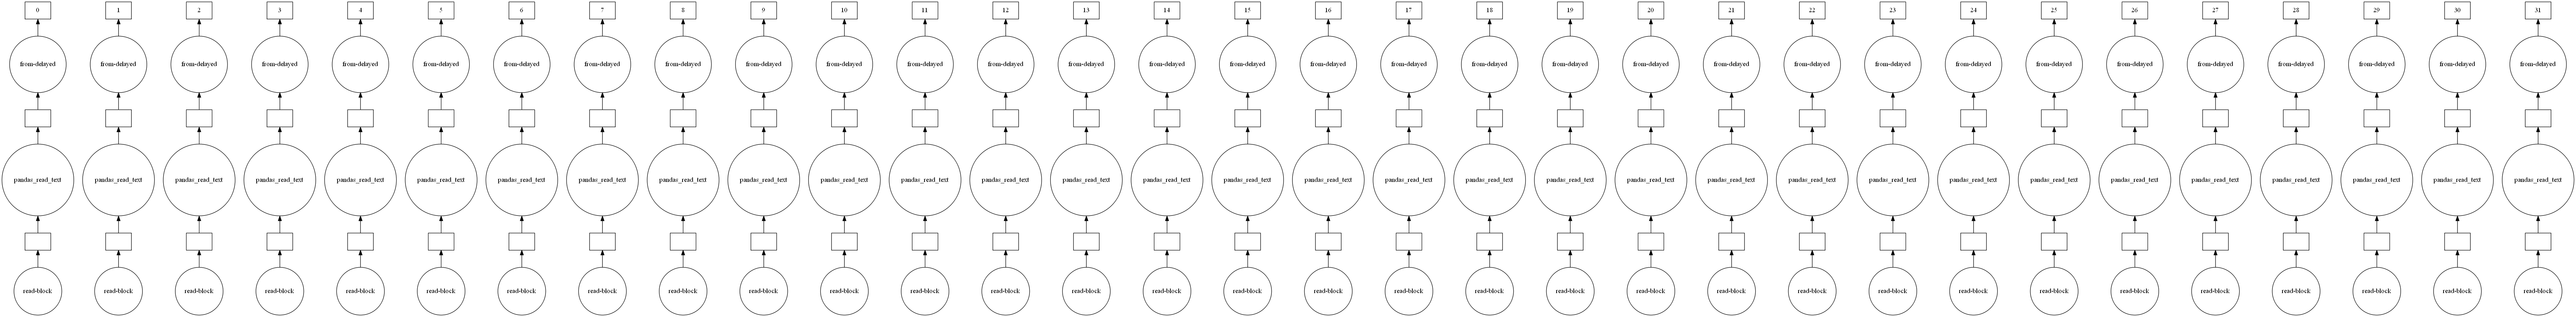

In [5]:
month.visualize()

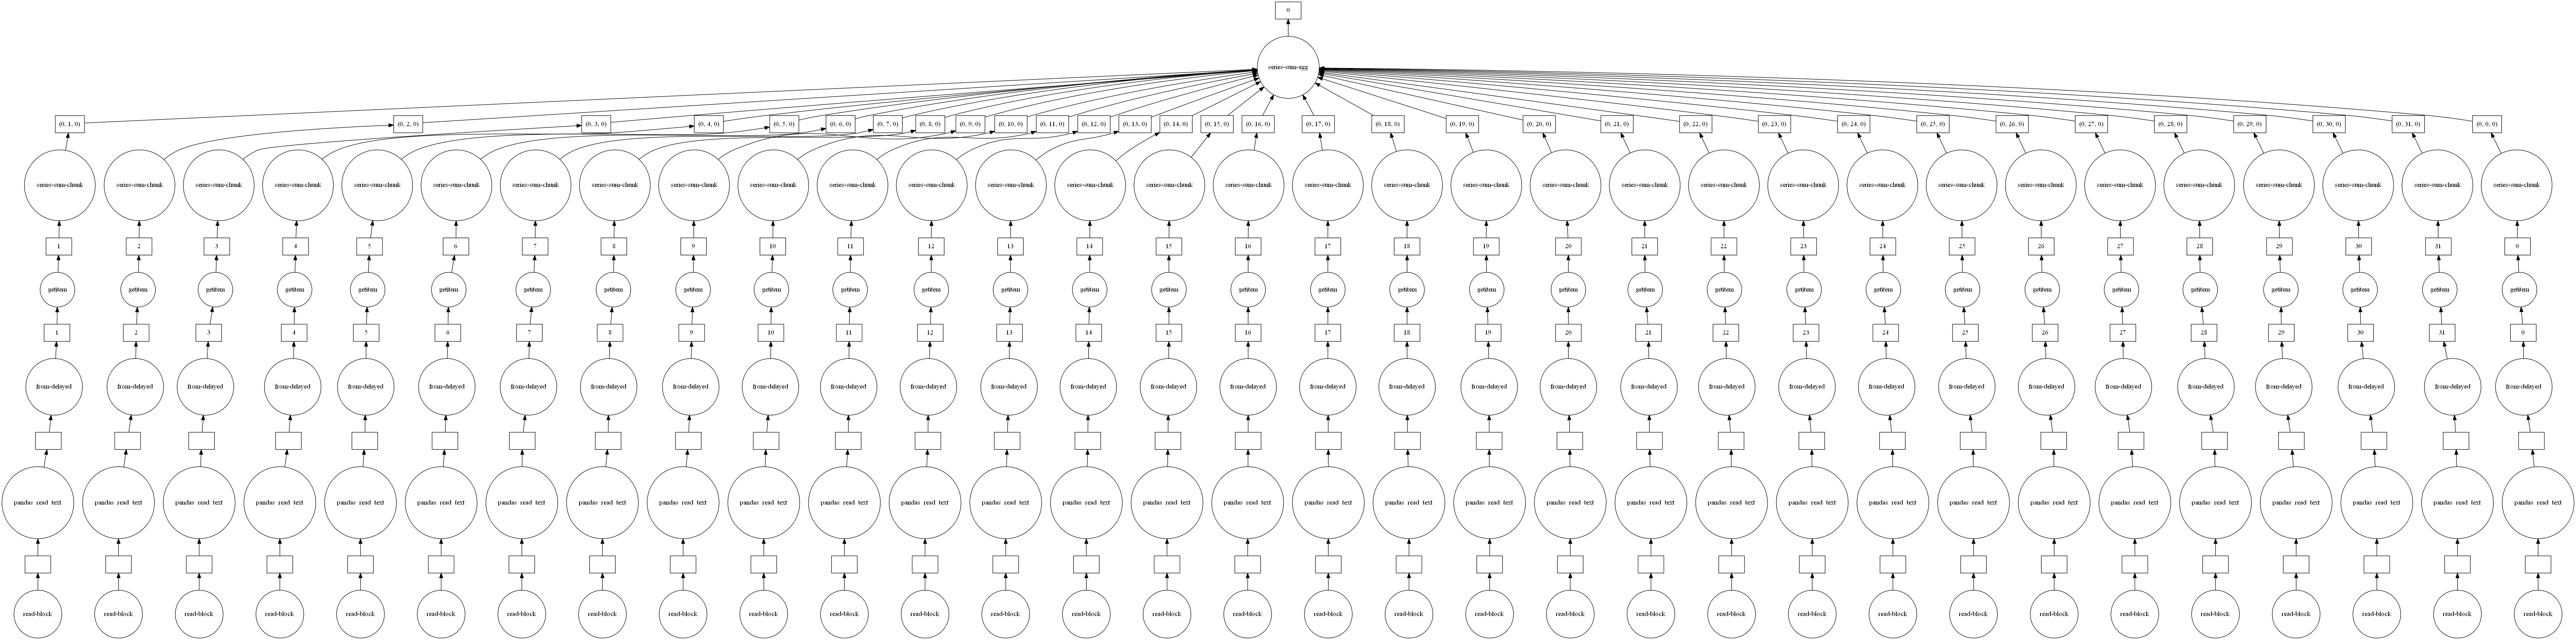

In [6]:
month.fare_amount.sum().visualize()

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [7]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [8]:
# Locations that are not of new york
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating map using folium
map= folium.Map(location=[40.7176,-73.9004], tiles='Stamen Toner')

# Adding markers to the map
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker([j['pickup_latitude'], j['pickup_longitude']]).add_to(map)
map

<b>Observation : </b> <p>-There are many points that doesn't belong to new york city.Infact some points are from africa , canada,

## 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [9]:
# Locations that are not of new york
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating map using folium
map= folium.Map(location=[40.7176,-73.9004], tiles='Stamen Toner')

# Adding markers to the map
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['dropoff_latitude']) != 0:
        folium.Marker([j['dropoff_latitude'], j['dropoff_longitude']]).add_to(map)
map

<b>Observation</b>
<p>-Number of dropoff marks are way more than pickup points (OUTSIDE NEW YORK)

### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [10]:
month.head(1)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05

In [11]:
#Defining fuction to Convert the timestamps to unix
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

''' 
WE return the dataframe with columns ==> 

    1. passenger_count : Self Explanatory
    2. trip_distance : Self Explanatory
    3. pickup_longitude : Self Explanatory
    4. pickup_latitude : Self Explanatory
    5. dropoff_longitude : Self Explanatory
    6. dropoff_latitude : Self Explanatory
    7. total_amount : Total fair amount that was paid
    8. trip_times : duration of each trip
    9. pickup_time : Self Explanatory
    10.speed : velocity of each trip
'''
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    # Converting the pickup time and drop off time to unix format
    pickup_time = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    dropoff_time = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # Computing the duration of the Trip
    duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)
    
    # Append the duration and speed in miles/hr to the new data frame
    new_df = month[['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude' \
                    , 'dropoff_latitude', 'total_amount']].compute()
    
    new_df['trip_times'] = duration
    new_df['pickup_time'] = pickup_time
    
    # Computing the Speed of each trip
    speed = (new_df['trip_distance']/new_df['trip_times'])*60
    
    new_df['speed'] = speed
    
    return new_df
my_frame_of_durations = return_with_trip_times(month)

In [12]:
my_frame_of_durations.head(5)

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

    pickup_time      speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

<IPython.core.display.Javascript object>


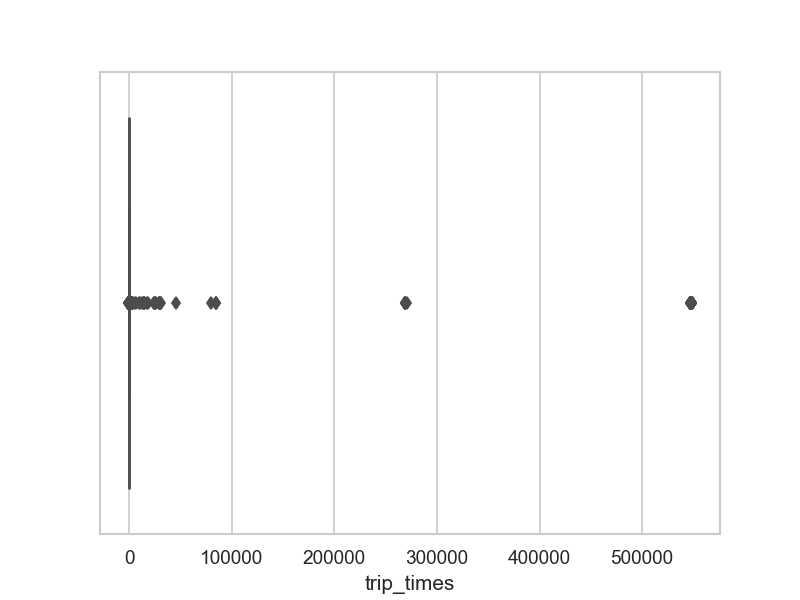

In [13]:
sns.set(style = 'whitegrid')
sns.boxplot(x = my_frame_of_durations['trip_times'])
plt.show()

In [14]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in range(0, 110, 10):
    print(i,'th percentile value of trip_times : ', np.percentile(my_frame_of_durations['trip_times'], i))

0 th percentile value of trip_times :  -1211.0166666666667
10 th percentile value of trip_times :  3.8333333333333335
20 th percentile value of trip_times :  5.383333333333334
30 th percentile value of trip_times :  6.816666666666666
40 th percentile value of trip_times :  8.3
50 th percentile value of trip_times :  9.95
60 th percentile value of trip_times :  11.866666666666667
70 th percentile value of trip_times :  14.283333333333333
80 th percentile value of trip_times :  17.633333333333333
90 th percentile value of trip_times :  23.45
100 th percentile value of trip_times :  548555.6333333333


In [15]:
# Now we will look for percentile values from 90 to 100
for i in range(90,101,1):
    print(i,'th percentile value of trip_times : ', np.percentile(my_frame_of_durations['trip_times'], i))

90 th percentile value of trip_times :  23.45
91 th percentile value of trip_times :  24.35
92 th percentile value of trip_times :  25.383333333333333
93 th percentile value of trip_times :  26.55
94 th percentile value of trip_times :  27.933333333333334
95 th percentile value of trip_times :  29.583333333333332
96 th percentile value of trip_times :  31.68333333333333
97 th percentile value of trip_times :  34.46666666666667
98 th percentile value of trip_times :  38.71666666666667
99 th percentile value of trip_times :  46.75
100 th percentile value of trip_times :  548555.6333333333


In [16]:
# Now we will look for percentile values from 99 to 100
i = 99.0
while i <= 100:
    print(i,'th percentile value of trip_times : ', np.percentile(my_frame_of_durations['trip_times'], i))
    i = i+0.1

99.0 th percentile value of trip_times :  46.75
99.1 th percentile value of trip_times :  48.06666666666667
99.19999999999999 th percentile value of trip_times :  49.56666666666667
99.29999999999998 th percentile value of trip_times :  51.28333333333333
99.39999999999998 th percentile value of trip_times :  53.31666666666667
99.49999999999997 th percentile value of trip_times :  55.833333333333336
99.59999999999997 th percentile value of trip_times :  59.13333333333333
99.69999999999996 th percentile value of trip_times :  63.9
99.79999999999995 th percentile value of trip_times :  71.86666666666666
99.89999999999995 th percentile value of trip_times :  101.6
99.99999999999994 th percentile value of trip_times :  548555.6333331489


In [17]:
# Now let's remove the outliers
frame_with_durations_modified = my_frame_of_durations[(my_frame_of_durations['trip_times']>1) & (my_frame_of_durations['trip_times'] < 720)]

<IPython.core.display.Javascript object>


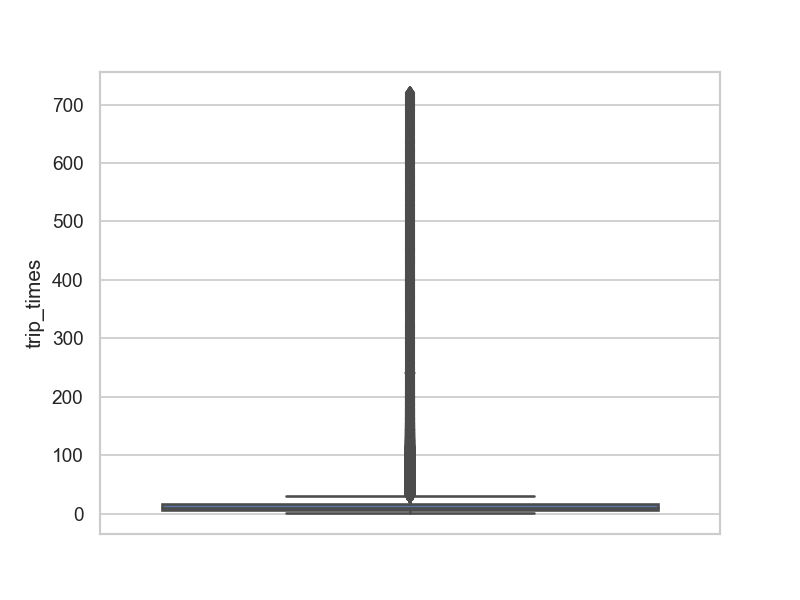

In [18]:
sns.set(style = 'whitegrid')
sns.boxplot(y = frame_with_durations_modified['trip_times'])
plt.show()

<IPython.core.display.Javascript object>


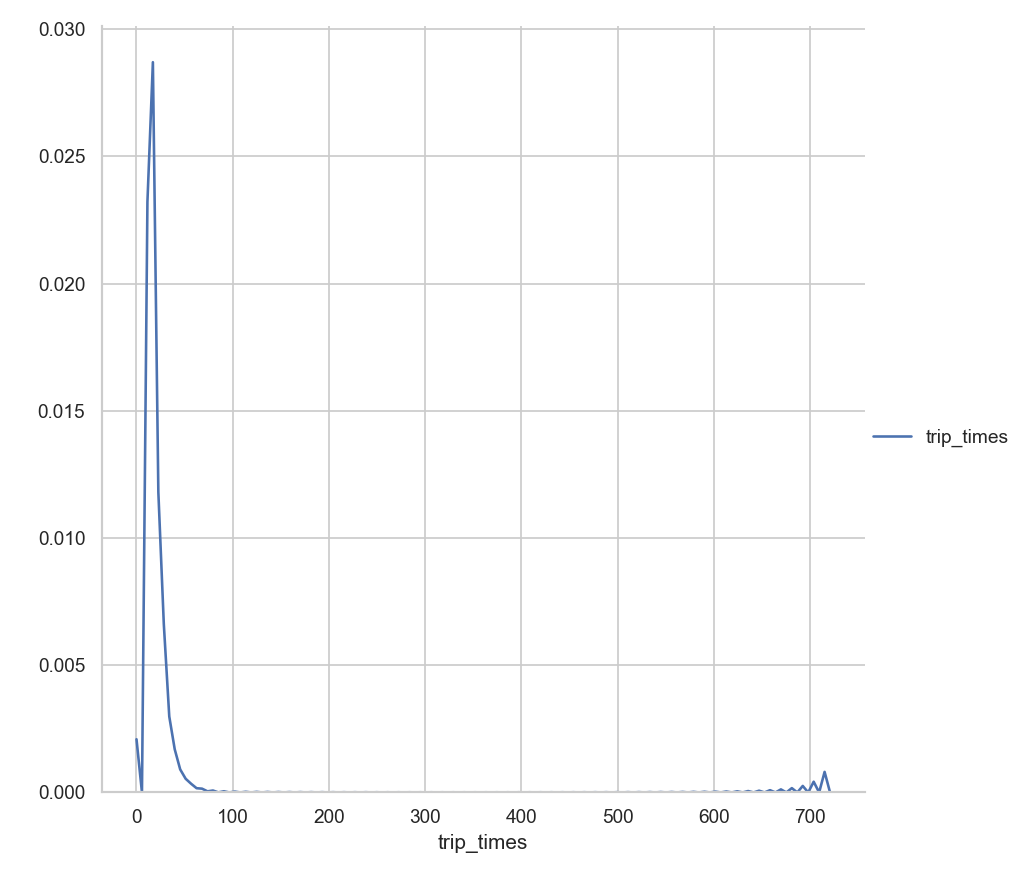

In [19]:
#Above boxplot isn't giving anymore clarity.So, take a look at pdf for trip_times
sns.FacetGrid(data = frame_with_durations_modified, size = 7) \
    .map(sns.kdeplot, 'trip_times') \
    .add_legend()
plt.show()

## Observation :
-It seems like a graph of log-normal, with little sharpness at left tail and few more point at the end of right tail.<br>
-Therefore we must check it's log graph

In [20]:
# Converting trip_times, column values to log values to check for log-normal
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


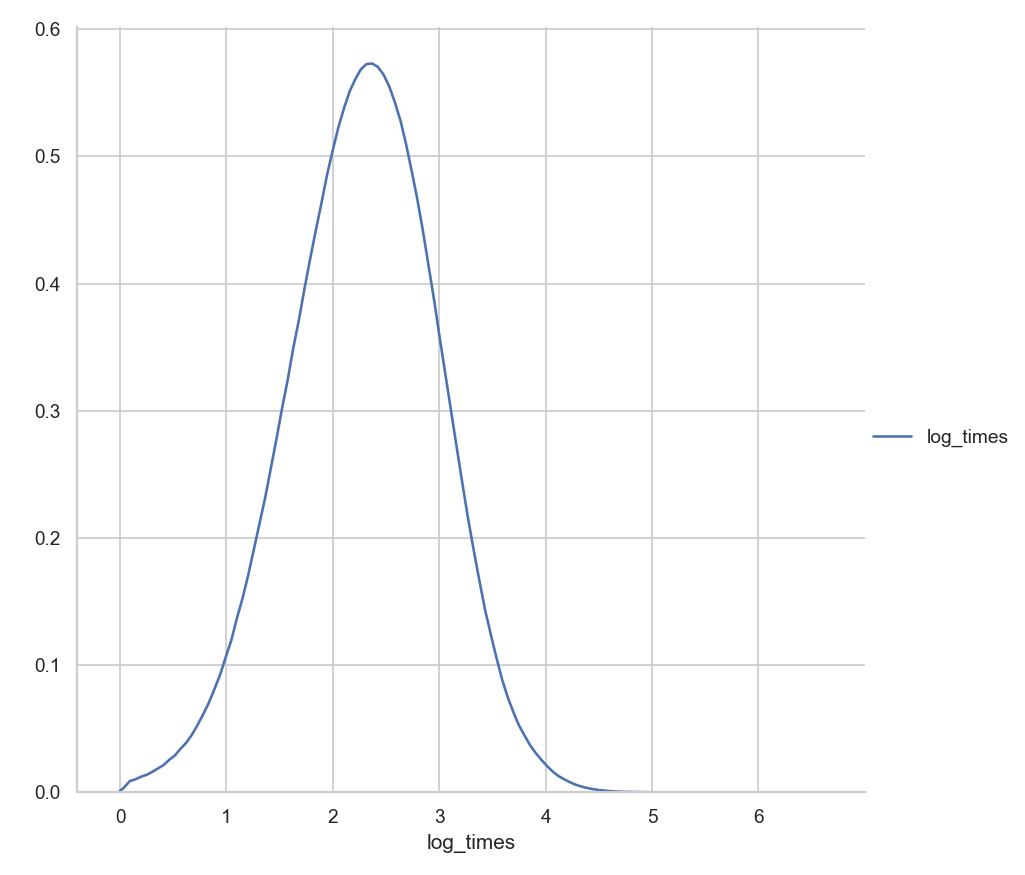

In [21]:
# Looking at the pdf of log of trip_times column
sns.FacetGrid(data = frame_with_durations_modified, size = 7) \
    .map(sns.kdeplot, 'log_times') \
    .add_legend()
plt.show()

<IPython.core.display.Javascript object>


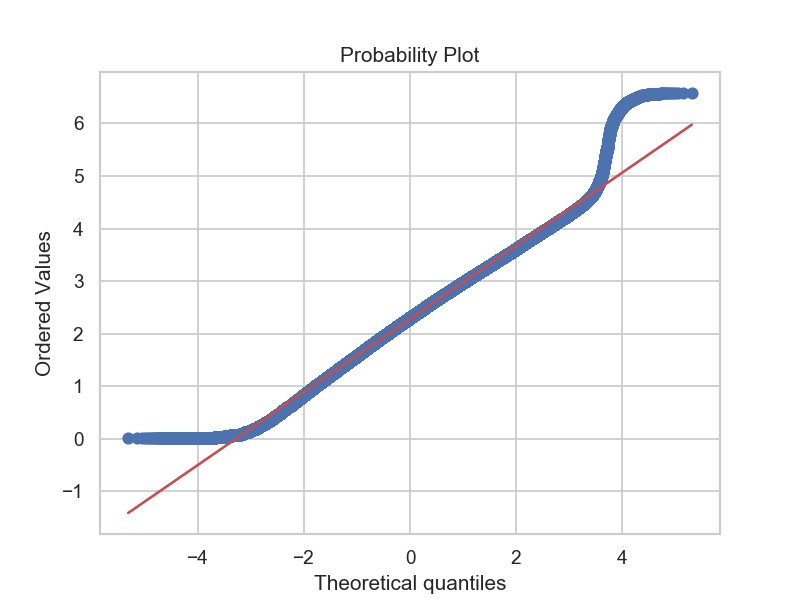

In [22]:
# Q-Q plot for checking if trip_times is log_normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed

<IPython.core.display.Javascript object>


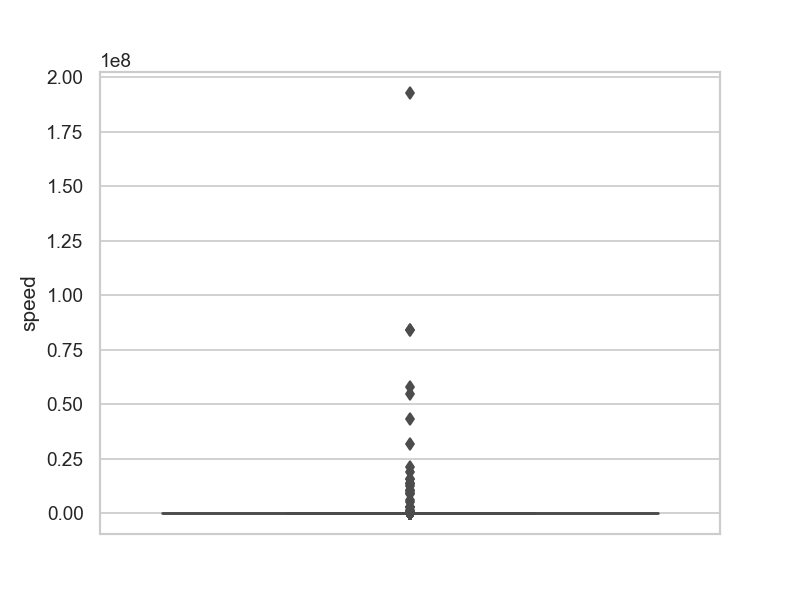

In [23]:
sns.set(style = 'whitegrid')
sns.boxplot(y = frame_with_durations_modified['speed'])
plt.show()

In [24]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in range(0, 110, 10):
    print(i,'th percentile value of speed : ', np.percentile(frame_with_durations_modified['speed'], i))

0 th percentile value of speed :  0.0
10 th percentile value of speed :  6.409495548961425
20 th percentile value of speed :  7.80952380952381
30 th percentile value of speed :  8.929133858267717
40 th percentile value of speed :  9.98019801980198
50 th percentile value of speed :  11.06865671641791
60 th percentile value of speed :  12.286689419795222
70 th percentile value of speed :  13.796407185628745
80 th percentile value of speed :  15.963224893917962
90 th percentile value of speed :  20.186915887850468
100 th percentile value of speed :  192857142.85714284


In [25]:
# Now we will look for percentile values from 90 to 100
for i in range(90,101,1):
    print(i,'th percentile value of speed : ', np.percentile(frame_with_durations_modified['speed'], i))

90 th percentile value of speed :  20.186915887850468
91 th percentile value of speed :  20.916454400875093
92 th percentile value of speed :  21.752988047808763
93 th percentile value of speed :  22.721893491124263
94 th percentile value of speed :  23.844155844155843
95 th percentile value of speed :  25.182552504038775
96 th percentile value of speed :  26.80851063829787
97 th percentile value of speed :  28.84304932735426
98 th percentile value of speed :  31.591128254580514
99 th percentile value of speed :  35.75135055113604
100 th percentile value of speed :  192857142.85714284


In [26]:
# Now we will look for percentile values from 90 to 100
for i in np.arange(99.0,100.1,0.1):
    print(i,'th percentile value of speed : ', np.percentile(frame_with_durations_modified['speed'], i))

99.0 th percentile value of speed :  35.75135055113604
99.1 th percentile value of speed :  36.31081290376664
99.19999999999999 th percentile value of speed :  36.91470054446461
99.29999999999998 th percentile value of speed :  37.588235294117645
99.39999999999998 th percentile value of speed :  38.33033429478857
99.49999999999997 th percentile value of speed :  39.17580011612376
99.59999999999997 th percentile value of speed :  40.15384615384615
99.69999999999996 th percentile value of speed :  41.33802908679603
99.79999999999995 th percentile value of speed :  42.866243893092424
99.89999999999995 th percentile value of speed :  45.31067507472189
99.99999999999994 th percentile value of speed :  192857142.04603058


In [43]:
# Removing the outlier considering 
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified['speed']>0) & (frame_with_durations_modified['speed']<45.31)] 

<IPython.core.display.Javascript object>


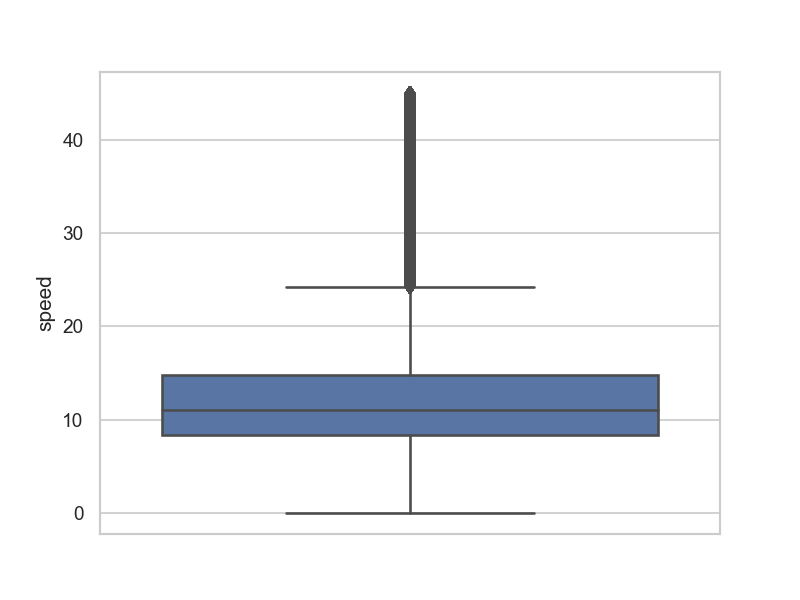

In [44]:
sns.set(style = 'whitegrid')
sns.boxplot(y = frame_with_durations_modified['speed'])
plt.show()

In [45]:
# Average Speed of the cap in the New York

frame_with_durations_modified['speed'].sum()/float(len(frame_with_durations_modified))

12.435492454278878

Average speed of the cap in New York is 12.435 mile/hr.So, cap can travel <font color='blue'> 2 mile in 10 minutes on avg.</font>

### 5.Trip distance

<IPython.core.display.Javascript object>


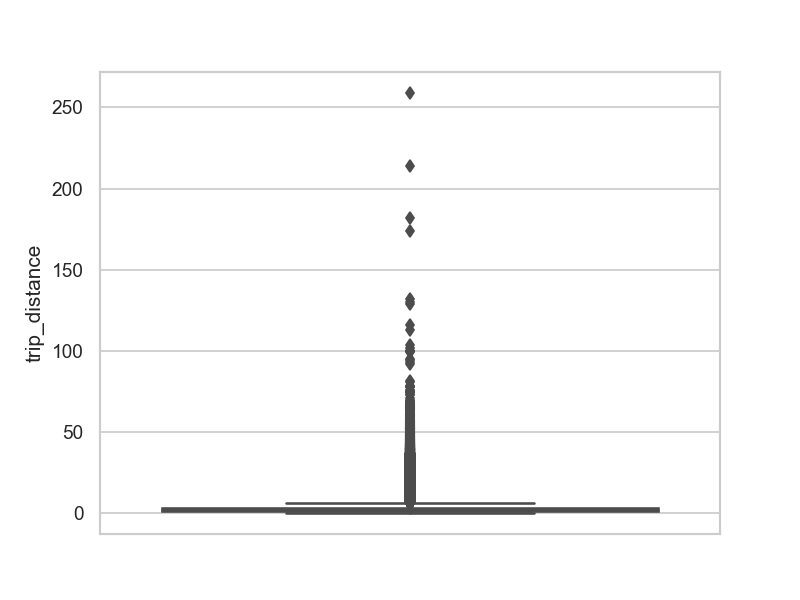

In [30]:
sns.boxplot(y = frame_with_durations_modified['trip_distance'])
plt.show()

In [31]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in range(0, 110, 10):
    print(i,'th percentile value of trip_distance : ', np.percentile(frame_with_durations_modified['trip_distance'], i))

0 th percentile value of trip_distance :  0.01
10 th percentile value of trip_distance :  0.67
20 th percentile value of trip_distance :  0.9000000000000001
30 th percentile value of trip_distance :  1.1
40 th percentile value of trip_distance :  1.39
50 th percentile value of trip_distance :  1.7
60 th percentile value of trip_distance :  2.08
70 th percentile value of trip_distance :  2.6
80 th percentile value of trip_distance :  3.6
90 th percentile value of trip_distance :  5.98
100 th percentile value of trip_distance :  258.9


In [32]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in range(90, 101, 1):
    print(i,'th percentile value of trip_distance : ', np.percentile(frame_with_durations_modified['trip_distance'], i))

90 th percentile value of trip_distance :  5.98
91 th percentile value of trip_distance :  6.46
92 th percentile value of trip_distance :  7.08
93 th percentile value of trip_distance :  7.86
94 th percentile value of trip_distance :  8.73
95 th percentile value of trip_distance :  9.6
96 th percentile value of trip_distance :  10.6
97 th percentile value of trip_distance :  12.1
98 th percentile value of trip_distance :  16.02
99 th percentile value of trip_distance :  18.16
100 th percentile value of trip_distance :  258.9


In [33]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in np.arange(99, 100.1, 0.1):
    print(i,'th percentile value of trip_distance : ', np.percentile(frame_with_durations_modified['trip_distance'], i))

99.0 th percentile value of trip_distance :  18.16
99.1 th percentile value of trip_distance :  18.36
99.19999999999999 th percentile value of trip_distance :  18.6
99.29999999999998 th percentile value of trip_distance :  18.82
99.39999999999998 th percentile value of trip_distance :  19.12
99.49999999999997 th percentile value of trip_distance :  19.5
99.59999999999997 th percentile value of trip_distance :  19.95
99.69999999999996 th percentile value of trip_distance :  20.5
99.79999999999995 th percentile value of trip_distance :  21.21
99.89999999999995 th percentile value of trip_distance :  22.54
99.99999999999994 th percentile value of trip_distance :  258.89999966248865


In [46]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified['trip_distance']>0) & (frame_with_durations_modified['trip_distance']<23)]

<IPython.core.display.Javascript object>


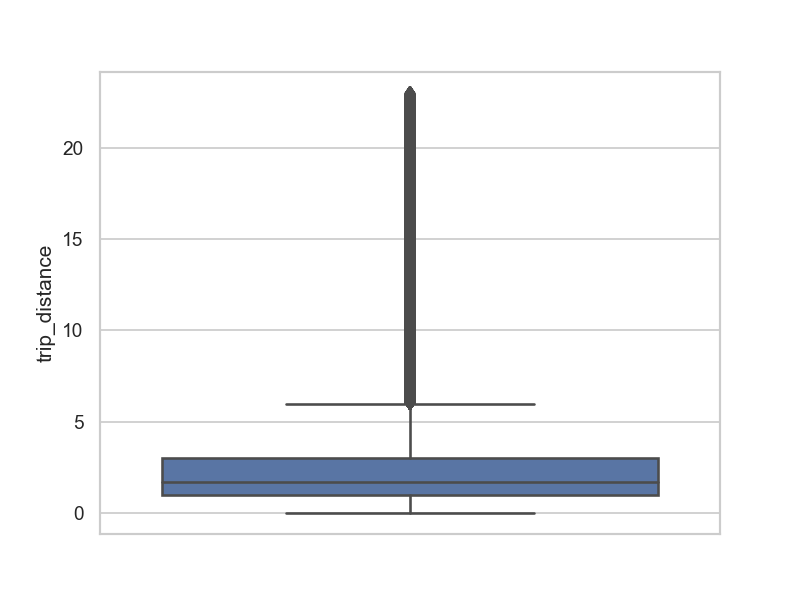

In [47]:
sns.boxplot(y = frame_with_durations_modified['trip_distance'])
plt.show()

### 6.Total Fare

<IPython.core.display.Javascript object>


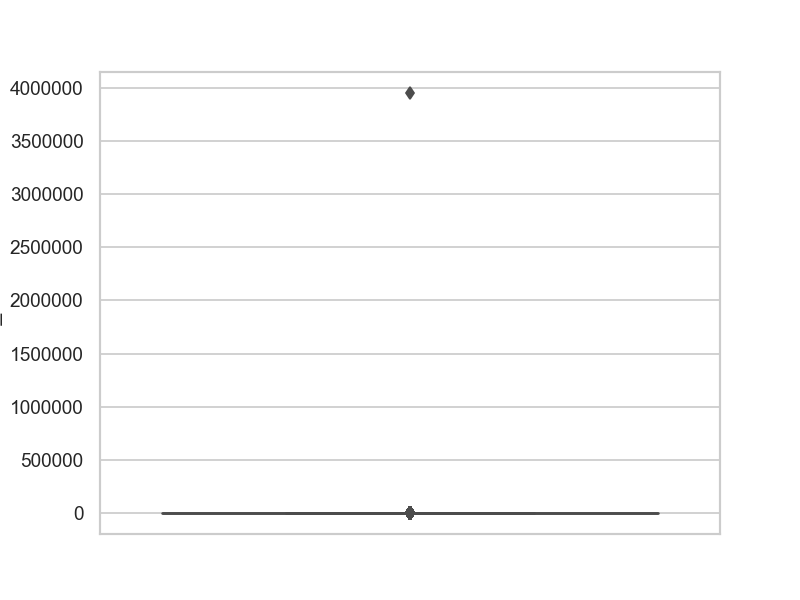

In [36]:
sns.set(style = 'whitegrid')
sns.boxplot(y = frame_with_durations_modified['total_amount'])
plt.show()

In [37]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in range(0, 110, 10):
    print(i,'th percentile value of total_amount : ', np.percentile(frame_with_durations_modified['total_amount'], i))

0 th percentile value of total_amount :  -242.55
10 th percentile value of total_amount :  6.35
20 th percentile value of total_amount :  7.8
30 th percentile value of total_amount :  8.8
40 th percentile value of total_amount :  9.8
50 th percentile value of total_amount :  11.16
60 th percentile value of total_amount :  12.8
70 th percentile value of total_amount :  14.8
80 th percentile value of total_amount :  18.3
90 th percentile value of total_amount :  25.8
100 th percentile value of total_amount :  3950611.6


In [38]:
#Looking for percentile value from 90 to 100 for finding correct percentile value for removal of ouliers
for i in range(90, 101, 1):
    print(i,'th percentile value of total_amount : ', np.percentile(frame_with_durations_modified['total_amount'], i))

90 th percentile value of total_amount :  25.8
91 th percentile value of total_amount :  27.3
92 th percentile value of total_amount :  29.15
93 th percentile value of total_amount :  31.55
94 th percentile value of total_amount :  34.63
95 th percentile value of total_amount :  38.15
96 th percentile value of total_amount :  42.13
97 th percentile value of total_amount :  47.6
98 th percentile value of total_amount :  57.8
99 th percentile value of total_amount :  66.0
100 th percentile value of total_amount :  3950611.6


In [39]:
#Looking for percentile value from 0 to 100 for finding correct percentile value for removal of ouliers
for i in np.arange(99, 100.1, 0.1):
    print(i,'th percentile value of total_amount : ', np.percentile(frame_with_durations_modified['total_amount'], i))

99.0 th percentile value of total_amount :  66.0
99.1 th percentile value of total_amount :  68.13
99.19999999999999 th percentile value of total_amount :  69.24
99.29999999999998 th percentile value of total_amount :  69.6
99.39999999999998 th percentile value of total_amount :  69.73
99.49999999999997 th percentile value of total_amount :  69.73
99.59999999999997 th percentile value of total_amount :  69.76
99.69999999999996 th percentile value of total_amount :  72.46
99.79999999999995 th percentile value of total_amount :  75.33
99.89999999999995 th percentile value of total_amount :  87.38233999993652
99.99999999999994 th percentile value of total_amount :  3950611.5705955215


### Observation
> 99.89 percentile doesn't seem to be outlier because there is not much differece in 99.79th and 99.89th.Hence, we are moving on to graphical analysis

<IPython.core.display.Javascript object>


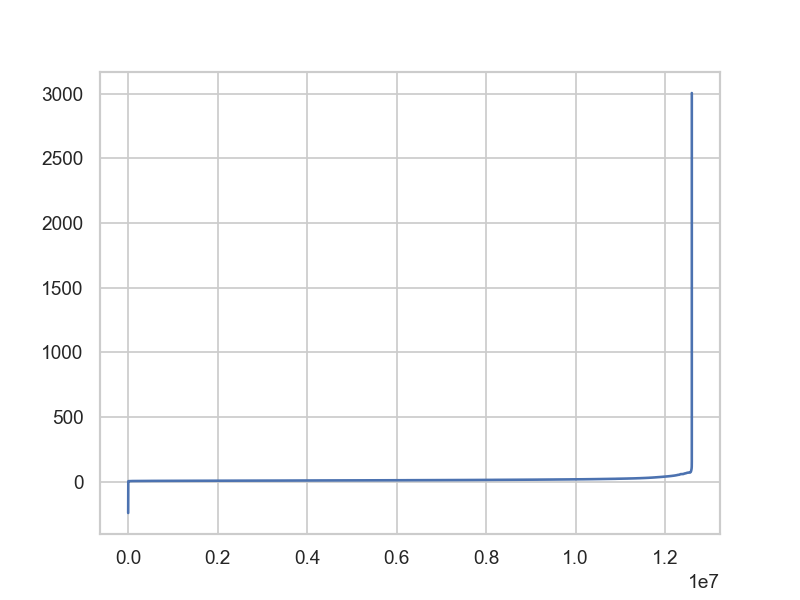

In [42]:
var = frame_with_durations_modified['total_amount'].values
var = np.sort(var,axis = None)
# this plot shows us the fare amount(sorted) to find out the sharp increase and remove outlier.
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>


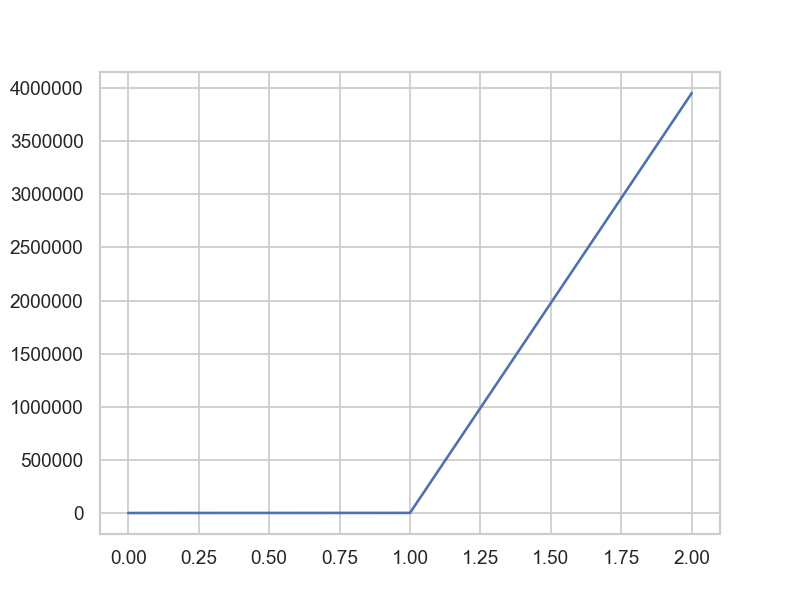

In [41]:
# this plot shows us the sharp increase in the fare amount
plt.plot(var[-3:])
plt.show()

<IPython.core.display.Javascript object>


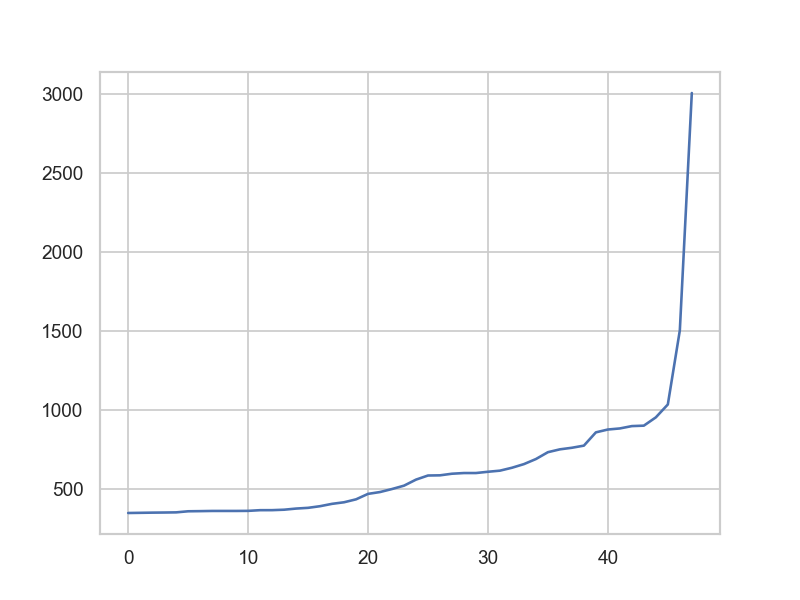

In [48]:
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [95]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.speed >=0) & (new_frame.speed <45.31)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1100) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1100) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [96]:
print ("Removing outliers in the month of Jan-2016")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(my_frame_of_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(my_frame_of_durations))

Removing outliers in the month of Jan-2016
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 36690
Number of outliers from fare analysis: 5273
Total outliers removed 377909
---
fraction of data points that remain after removing outliers 0.9703577209983602


# Data-preperation
## Clustering/Segmentation

Next part of our analysis is data preperation in which we will do
1. Clustering of regions 
2. 10 minutes time bin

## 1. Clustering of regions - :
    1.1 : the features on the basis of what region will be divided -: longitude and latitude
    1.2 : K-mean (Now the question is what will be the optimal k for k-means)
         
Now K-means has property that it creates clusters of roughly same size, here size refers to the number of points not the area.
Since the number of pickups is highest in Manhattan area of NYC.Hence, the area of region will be much smaller in Manhattan than other outskirt areas of New York. 

We want intercluster distance to be less than 2 miles but again region should not  be less than 0.5 miles otherwise cluster will be way  too small.(distance measure from center of cluster)

In [53]:
from haversine import haversine, Unit

In [101]:
#trying different cluster sizes to choose the right value of k in k-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours = []

def find_min_distance(cluster_centers, cluster_len):
    less2 = []
    more2 = []
    min_distance = 100000 ## Just a random big number
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if i!=j:
                distance = haversine((cluster_centers[i][0], cluster_centers[i][1]), (cluster_centers[j][0], cluster_centers[j][1]), unit=Unit.MILES )
                min_distance = min(min_distance, distance)
                if distance < 2.0:
                    nice_points +=1
                else:
                    wrong_points +=1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print('For Cluster size =',cluster_len)
    print('Avg Number of Cluster within the vicinity (distance < 2 mile) : ', np.ceil(sum(less2)/len(less2)))
    print('Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) : ', np.ceil(sum(more2)/len(more2)))
    print('Minimum InterCluster distance : ', min_distance)
    print('\n')
    
def find_cluster(k_value):
    kmeans = MiniBatchKMeans(n_clusters=k_value, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for i in range(10, 100, 10):
    cluster_centers, cluster_len = find_cluster(i)
    find_min_distance(cluster_centers, cluster_len)

For Cluster size = 10
Avg Number of Cluster within the vicinity (distance < 2 mile) :  2.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  8.0
Minimum InterCluster distance :  0.961174863275153


For Cluster size = 20
Avg Number of Cluster within the vicinity (distance < 2 mile) :  5.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  15.0
Minimum InterCluster distance :  0.5868867184996208


For Cluster size = 30
Avg Number of Cluster within the vicinity (distance < 2 mile) :  6.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  23.0
Minimum InterCluster distance :  0.549202907265146


For Cluster size = 40
Avg Number of Cluster within the vicinity (distance < 2 mile) :  10.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  30.0
Minimum InterCluster distance :  0.36383822244154285


For Cluster size = 50
Avg Number of Cluster within the vicinity (distance < 2 mile) :  12.0
Avg NUmebr of Cluster outside the vicinity (d

### Observation :
Min InterCluster distance should not be less than 0.5 mile
at k = 30 , min intercluster dist is 0.51,  less2 ==> 0.26

At k = 40, min intercluster dist. is 0.50,  less2 ==> 0.225
at K = 50 , min intercluster dist is 0.34 , which mean it has reduced way too much.

So, we will consider k = 40 as optimal cluster

In [100]:
 for i in range(31,37,1):
    cluster_centers, cluster_len = find_cluster(i)
    find_min_distance(cluster_centers, cluster_len)

For Cluster size = 31
Avg Number of Cluster within the vicinity (distance < 2 mile) :  8.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  23.0
Minimum InterCluster distance :  0.5271021480096594


For Cluster size = 32
Avg Number of Cluster within the vicinity (distance < 2 mile) :  8.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  24.0
Minimum InterCluster distance :  0.4219625793182059


For Cluster size = 33
Avg Number of Cluster within the vicinity (distance < 2 mile) :  8.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  25.0
Minimum InterCluster distance :  0.4201373862540983


For Cluster size = 34
Avg Number of Cluster within the vicinity (distance < 2 mile) :  9.0
Avg NUmebr of Cluster outside the vicinity (distance > 2 mile) :  25.0
Minimum InterCluster distance :  0.4209835103489633


For Cluster size = 35
Avg Number of Cluster within the vicinity (distance < 2 mile) :  8.0
Avg NUmebr of Cluster outside the vicinity (d

In [89]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.36 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 

kmeans = MiniBatchKMeans(n_clusters= 35 , batch_size=10000,random_state=42).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [57]:
frame_with_durations_outliers_removed['pickup_cluster']

0         4
1        36
2        37
3        22
4         0
         ..
12615     6
12616    39
12617    30
12618    20
12619    21
Name: pickup_cluster, Length: 12371076, dtype: int32

### Plotting the cluster centers:

In [58]:
# Plotting the cluster centers on OSM(Open Street Map)
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
m = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(location=[cluster_centers[i][0], cluster_centers[i][1]], popup=str(cluster_centers[i])).add_to(m)
m

### Plotting the clusters:

In [59]:
def plot_cluster(frame): 
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    plt.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    plt.xlim(city_long_border)
    plt.ylim(city_lat_border)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
plot_cluster(frame_with_durations_outliers_removed)

<IPython.core.display.Javascript object>

## Time-binning

In [60]:
frame_with_durations_outliers_removed.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

    pickup_time      speed  pickup_cluster  
0  1.421329e+09   5.285319               4  
1  1.420902e+09   9.983193              36  
2  1.420902e+09  10.746269              37  
3  1.420902e+09  16.071429              22  
4  1.420902e+09   9.318378               0

In [90]:
###### Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00


def add_pickup_bins(frame,month,year):
    unix_pickup_times = [i for i in frame['pickup_time'].values]
    unix_time = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix = unix_time[year - 2015][month - 1]
    time_10min_bin = [ (int( (i - start_pickup_unix)/600 )+ 33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(time_10min_bin)
    return frame

In [54]:
# In the above function we are just subtracting the pickup time from the unix time of 12:00AM 1st (Jan-jun) 2015, and after that we 
# are dividing that with 600 in order to make a 10minute bin, that's it.
#For Jan 2016 data we are just subtracting its corresponding pickup time from the unix time of 12:00AM 1st (Jan-jun) 2016.

In [91]:
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [92]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015_frame["pickup_bins"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  4464


In [93]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

    pickup_time      speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319               4         2130  
1  1.420902e+09   9.983193              36         1419  
2  1.420902e+09  10.746269              37         1419  
3  1.420902e+09  16.071429              22         1419  
4  1.420902e+09   9.318378               0         1419

In [94]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                       89
               2                      191
               3                      300
               4                      288
               5                      318

In [74]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

# upto now we cleaned data and prepared data for the month 2016,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 31018
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 31866
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

In [75]:
jan_2016_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
5                2           5.52        -73.980118        40.743050   
6                2           7.45        -73.994057        40.719990   
7                1           1.20        -73.979424        40.744614   
8                1           6.00        -73.947151        40.791046   
9                1           3.21        -73.998344        40.723896   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
5         -73.913490         40.763142          20.3       18.50   
6         -73.966362         40.789871          27.3       26.75   
7         -73.992035         40.753944          10.3       11.90   
8         -73.920769         40.865578          19.3       11.20   
9         -73.995850         40.688400          12.8       11.10   

    pickup_time      speed  pickup_cluster  pickup_bins  
5  1.451587e+09  17.902703              18            0  
6  1.451587e+09  16.710280               2            0  
7  1.451587e+09   6.050420              30            1  
8  1.451587e+09  32.142857               6            1  
9  1.451587e+09  17.351351              36            1

In [76]:
jan_2016_groupby.tail()

trip_distance
pickup_cluster pickup_bins               
39             4459                    60
               4460                    54
               4461                    57
               4462                    51
               4463                    57

## Smoothing

In [77]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups

def unq_10min_bin(frame):
    values = []
    for i in range(0,40): # 30 is the number of Cluster
        new_frame = frame[frame['pickup_cluster'] == i]
        unq_bin = list(set(new_frame['pickup_bins']))
        unq_bin.sort()
        values.append(unq_bin)
    return values


In [78]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = unq_10min_bin(jan_2015_frame)
jan_2016_unique = unq_10min_bin(jan_2016_frame)

#feb
feb_2016_unique = unq_10min_bin(feb_2016_frame)

#march
mar_2016_unique = unq_10min_bin(mar_2016_frame)

In [81]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015_frame["pickup_bins"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  4464


In [80]:
# For each cluster's 10minbin with 0 pickups
for i in range(40):
    print('For ', i,'th cluster , number of 10min bins with 0 pickups are = ', 4465 - len(jan_2015_unique[i]))
    print('='*70)

For  0 th cluster , number of 10min bins with 0 pickups are =  28
For  1 th cluster , number of 10min bins with 0 pickups are =  152
For  2 th cluster , number of 10min bins with 0 pickups are =  35
For  3 th cluster , number of 10min bins with 0 pickups are =  428
For  4 th cluster , number of 10min bins with 0 pickups are =  44
For  5 th cluster , number of 10min bins with 0 pickups are =  52
For  6 th cluster , number of 10min bins with 0 pickups are =  24
For  7 th cluster , number of 10min bins with 0 pickups are =  33
For  8 th cluster , number of 10min bins with 0 pickups are =  36
For  9 th cluster , number of 10min bins with 0 pickups are =  116
For  10 th cluster , number of 10min bins with 0 pickups are =  32
For  11 th cluster , number of 10min bins with 0 pickups are =  39
For  12 th cluster , number of 10min bins with 0 pickups are =  35
For  13 th cluster , number of 10min bins with 0 pickups are =  42
For  14 th cluster , number of 10min bins with 0 pickups are =  83
Fo

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [82]:
# Fills a value of zero for every bin where no pickup data is present 
# the number_of_pickups: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# corresp_time_bin: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the number_of_pickups[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data

def fill_missing(number_of_pickups,corresp_time_bin):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464): # 4464 is the total number of time_bin in jan_2016
            if i in corresp_time_bin[r]:
                smoothed_bins.append(number_of_pickups[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [83]:
jan_2015_fills = fill_missing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

In [84]:
def smoothings(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:#searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        print('We are on ',r,'th cluster.....')
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [85]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fills = fill_missing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooths = smoothings(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

We are on  0 th cluster.....
We are on  1 th cluster.....
We are on  2 th cluster.....
We are on  3 th cluster.....
We are on  4 th cluster.....
We are on  5 th cluster.....
We are on  6 th cluster.....
We are on  7 th cluster.....
We are on  8 th cluster.....
We are on  9 th cluster.....
We are on  10 th cluster.....
We are on  11 th cluster.....
We are on  12 th cluster.....
We are on  13 th cluster.....
We are on  14 th cluster.....
We are on  15 th cluster.....
We are on  16 th cluster.....
We are on  17 th cluster.....
We are on  18 th cluster.....
We are on  19 th cluster.....
We are on  20 th cluster.....
We are on  21 th cluster.....
We are on  22 th cluster.....
We are on  23 th cluster.....
We are on  24 th cluster.....
We are on  25 th cluster.....
We are on  26 th cluster.....
We are on  27 th cluster.....
We are on  28 th cluster.....
We are on  29 th cluster.....
We are on  30 th cluster.....
We are on  31 th cluster.....
We are on  32 th cluster.....
We are on  33 th clu

<IPython.core.display.Javascript object>


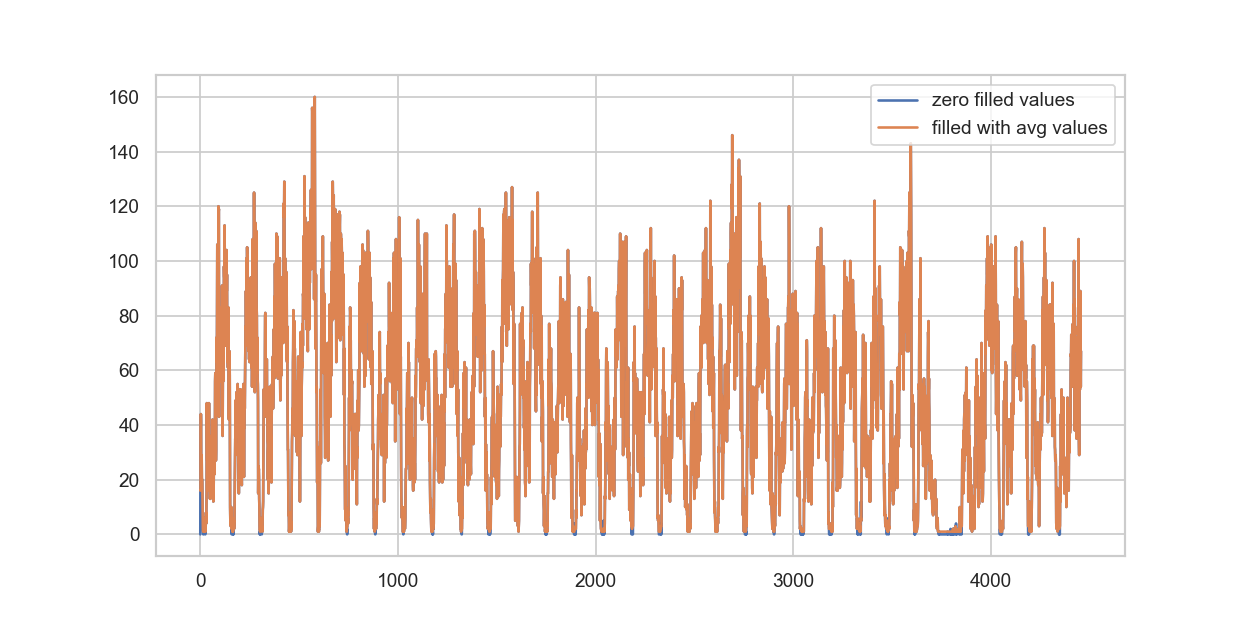

In [86]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fills[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooths[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [71]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fills = fill_missing(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooths = smoothings(jan_2015_groupby['trip_distance'].values, jan_2015_unique)

We are on  0 th cluster.....
We are on  1 th cluster.....
We are on  2 th cluster.....
We are on  3 th cluster.....
We are on  4 th cluster.....
We are on  5 th cluster.....
We are on  6 th cluster.....
We are on  7 th cluster.....
We are on  8 th cluster.....
We are on  9 th cluster.....
We are on  10 th cluster.....
We are on  11 th cluster.....
We are on  12 th cluster.....
We are on  13 th cluster.....
We are on  14 th cluster.....
We are on  15 th cluster.....
We are on  16 th cluster.....
We are on  17 th cluster.....
We are on  18 th cluster.....
We are on  19 th cluster.....
We are on  20 th cluster.....
We are on  21 th cluster.....
We are on  22 th cluster.....
We are on  23 th cluster.....
We are on  24 th cluster.....
We are on  25 th cluster.....
We are on  26 th cluster.....
We are on  27 th cluster.....
We are on  28 th cluster.....
We are on  29 th cluster.....
We are on  30 th cluster.....


In [72]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fills[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooths[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [73]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [87]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero

jan_2015_smooth = smoothings(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)



We are on  0 th cluster.....
We are on  1 th cluster.....
We are on  2 th cluster.....
We are on  3 th cluster.....
We are on  4 th cluster.....
We are on  5 th cluster.....
We are on  6 th cluster.....
We are on  7 th cluster.....
We are on  8 th cluster.....
We are on  9 th cluster.....
We are on  10 th cluster.....
We are on  11 th cluster.....
We are on  12 th cluster.....
We are on  13 th cluster.....
We are on  14 th cluster.....
We are on  15 th cluster.....
We are on  16 th cluster.....
We are on  17 th cluster.....
We are on  18 th cluster.....
We are on  19 th cluster.....
We are on  20 th cluster.....
We are on  21 th cluster.....
We are on  22 th cluster.....
We are on  23 th cluster.....
We are on  24 th cluster.....
We are on  25 th cluster.....
We are on  26 th cluster.....
We are on  27 th cluster.....
We are on  28 th cluster.....
We are on  29 th cluster.....
We are on  30 th cluster.....
We are on  31 th cluster.....
We are on  32 th cluster.....
We are on  33 th clu

In [75]:
region_with_pickups = []

# number of 10min bin for jan 2015= 24*31*60/10 = 4464
# number of 10min bin for jan 2016 = 24*31*60/10 = 4464
# number of 10min bin for feb 2016 = 24*29*60/10 = 4176
# number of 10min bin for march 2016 = 24*31*60/10 = 4464
# region_with_pickups : it is list of 31 lists,each representing different cluster. Each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data 

for i in range(40):
    region_with_pickups.append(jan_2016_smooth[i*4464 : (i+1)*4464] + feb_2016_smooth[i*4176: (i+1)*4176] + mar_2016_smooth[i*4464 : (i+1)*4464])

print(len(region_with_pickups))
print(len(region_with_pickups[0]))

31
13104


## Time series and Fourier Transforms

In [76]:
4464+4176+4464

13104

In [77]:
jan_x = list(range(4464))
feb_x = list(range(4464,8640))
mar_x = list(range(8640,13104 ))
for i in range(40):
    plt.figure(figsize = (9, 5))
    plt.plot(jan_x, region_with_pickups[i][:4464], label= 'jan 2016')
    plt.plot(feb_x, region_with_pickups[i][4464:8640],label = 'feb 2016')
    plt.plot(mar_x, region_with_pickups[i][8640:13104], label = 'mar 2016')
    plt.title('Cluster Wise pattern of Pickup with 10 minute timebin')
    plt.xlabel('10 minute Time Bins')
    plt.ylabel('Number of PickUps')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


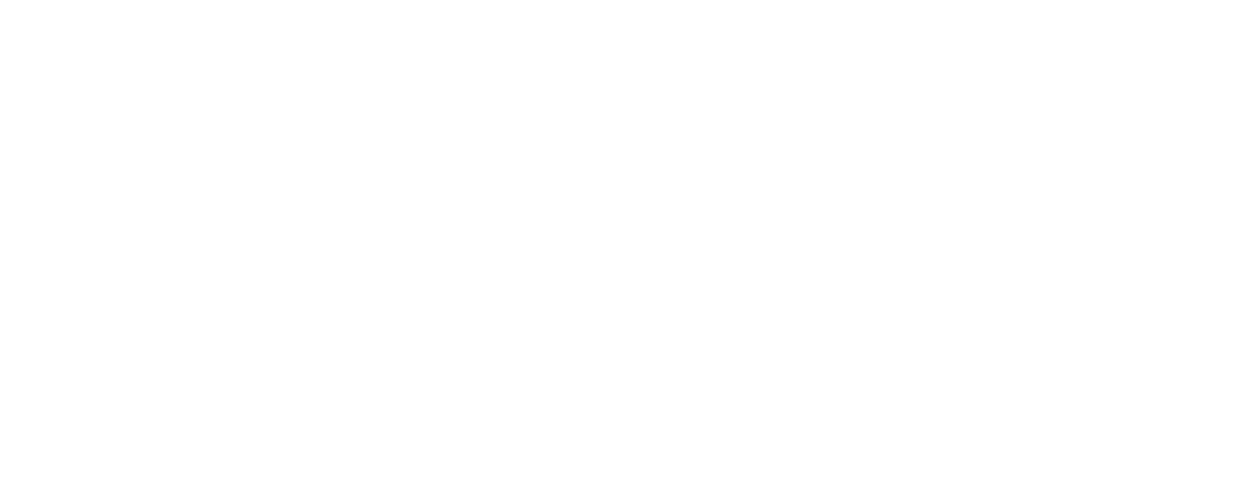

<IPython.core.display.Javascript object>


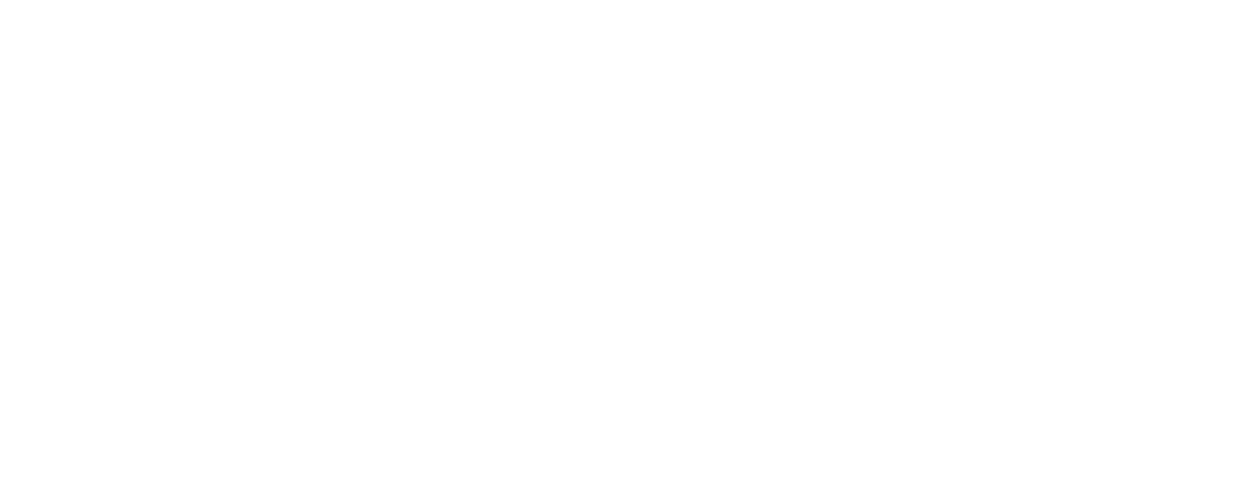

<IPython.core.display.Javascript object>


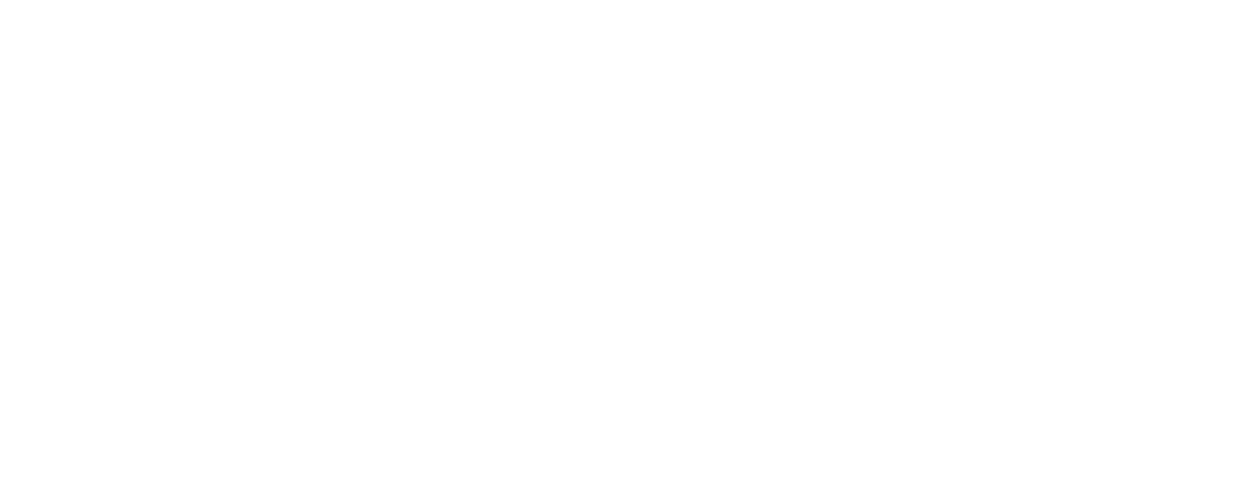

<IPython.core.display.Javascript object>


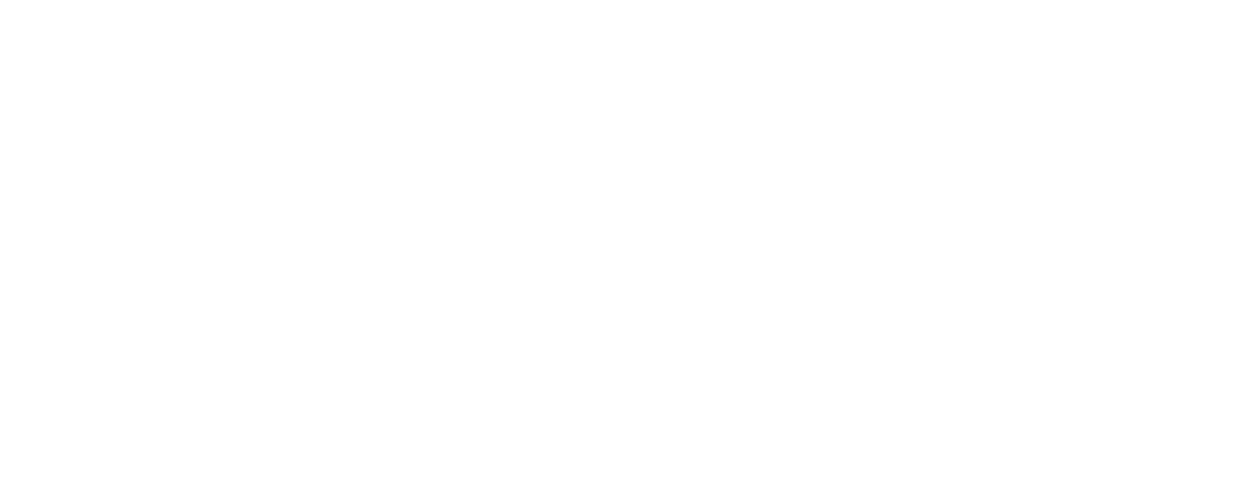

<IPython.core.display.Javascript object>


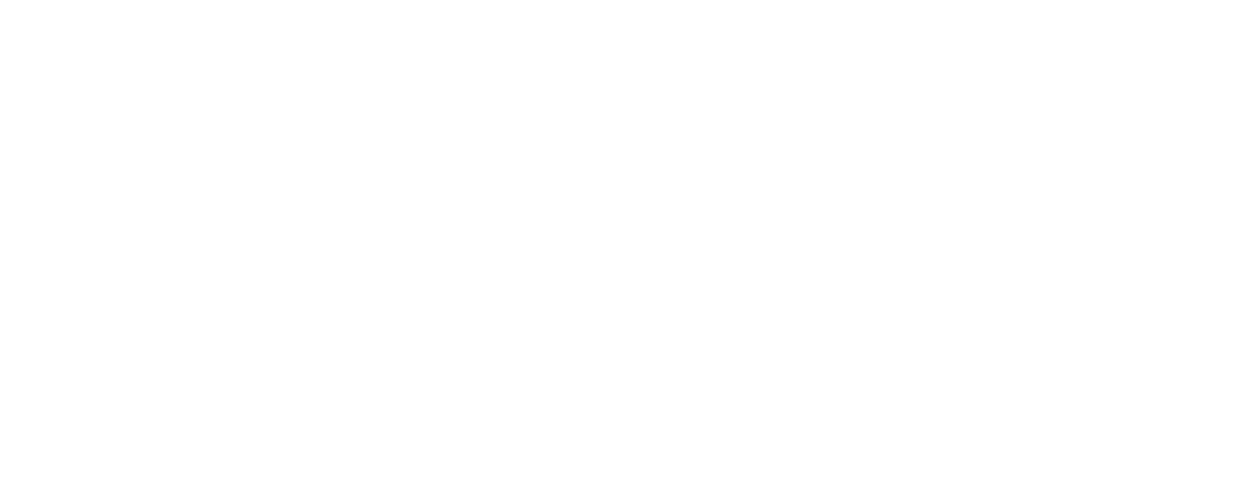

<IPython.core.display.Javascript object>


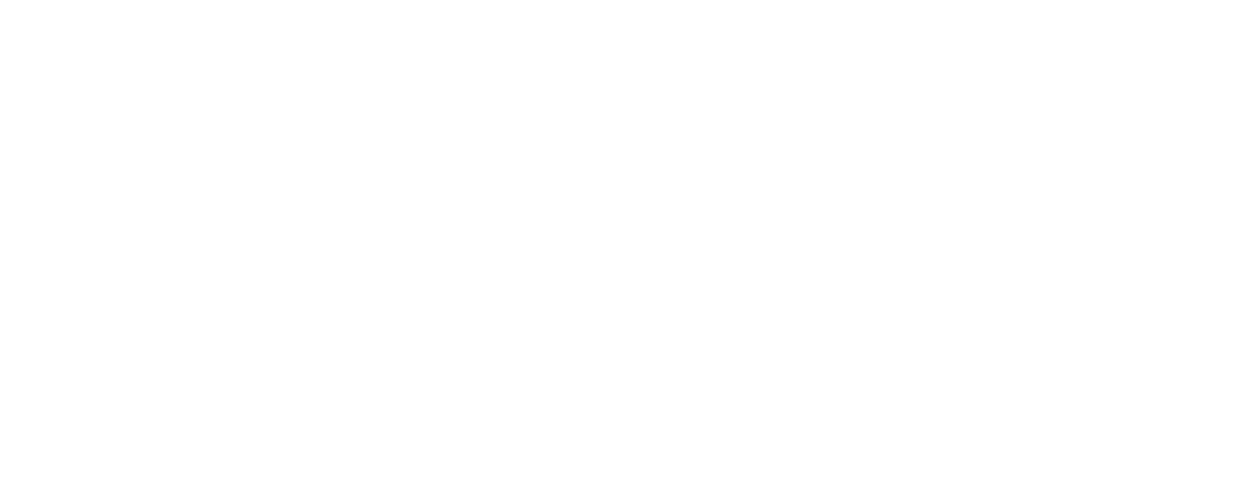

<IPython.core.display.Javascript object>


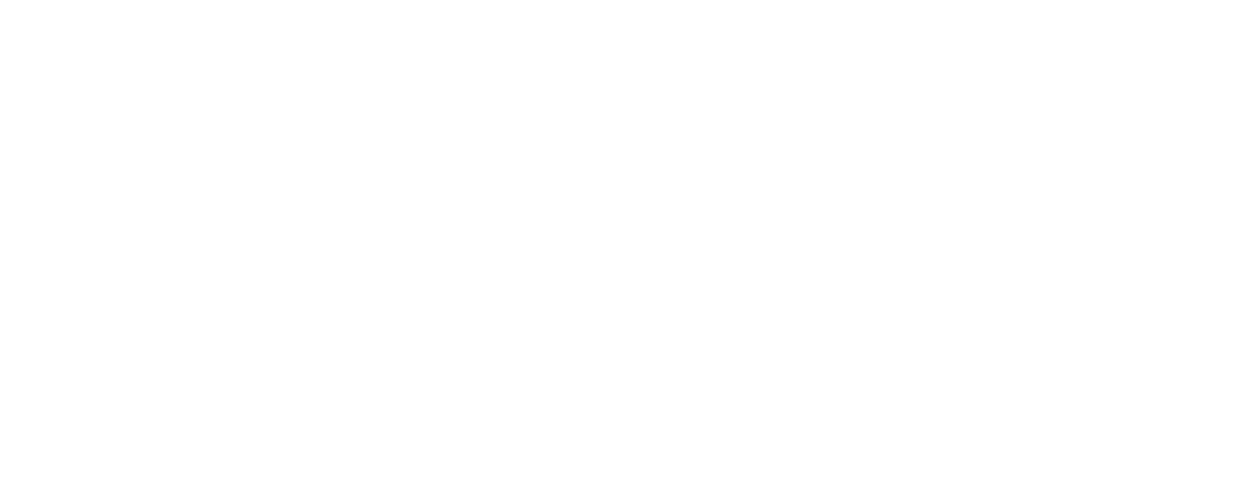

<IPython.core.display.Javascript object>


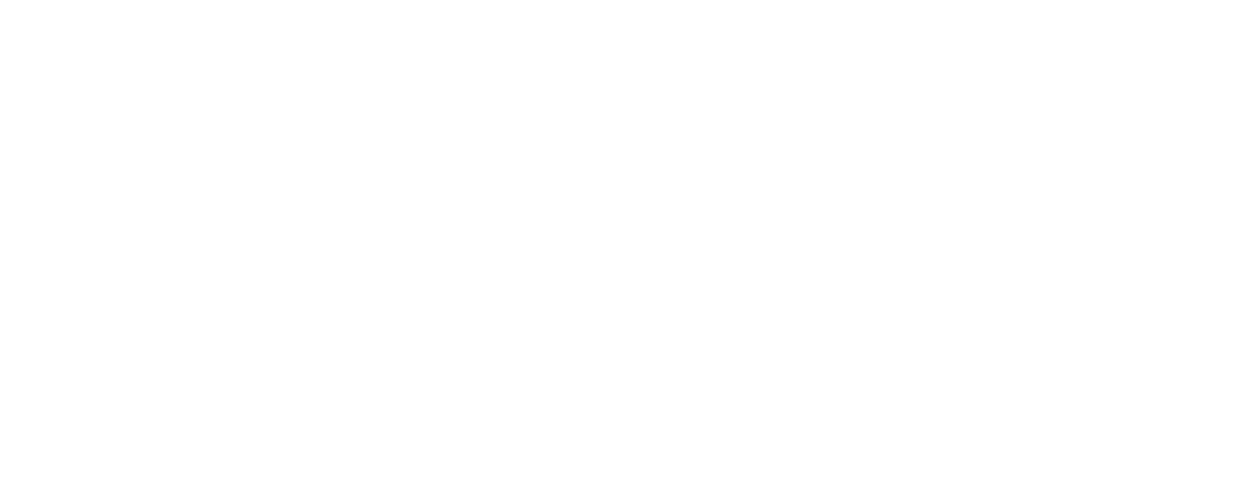

<IPython.core.display.Javascript object>


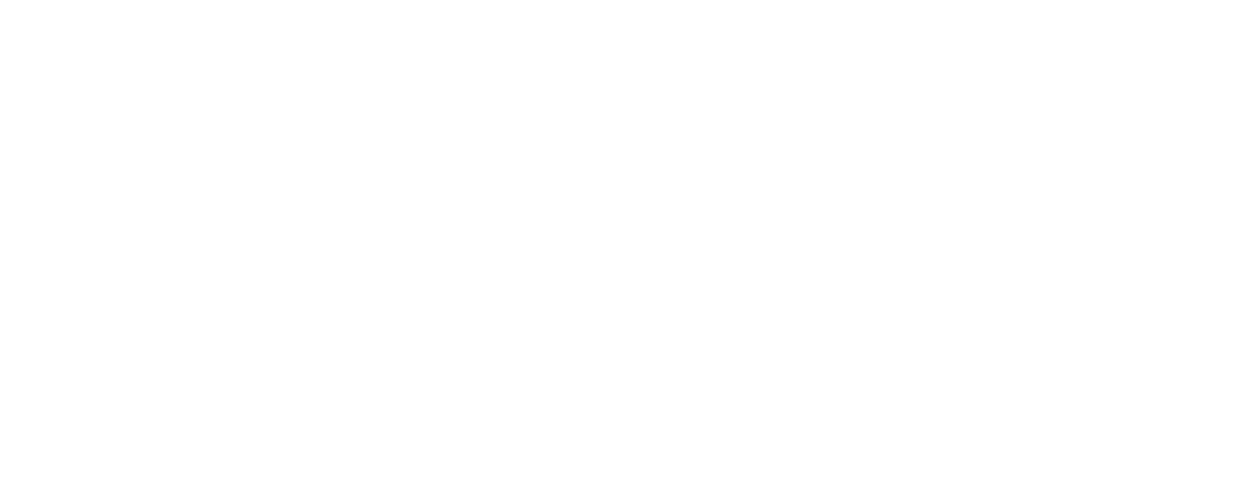

<IPython.core.display.Javascript object>


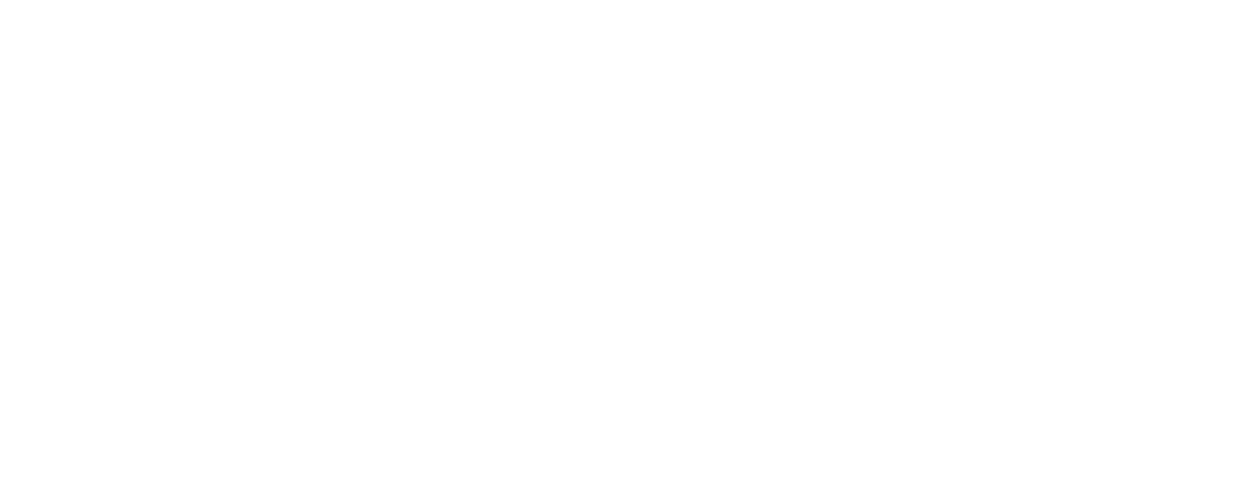

<IPython.core.display.Javascript object>


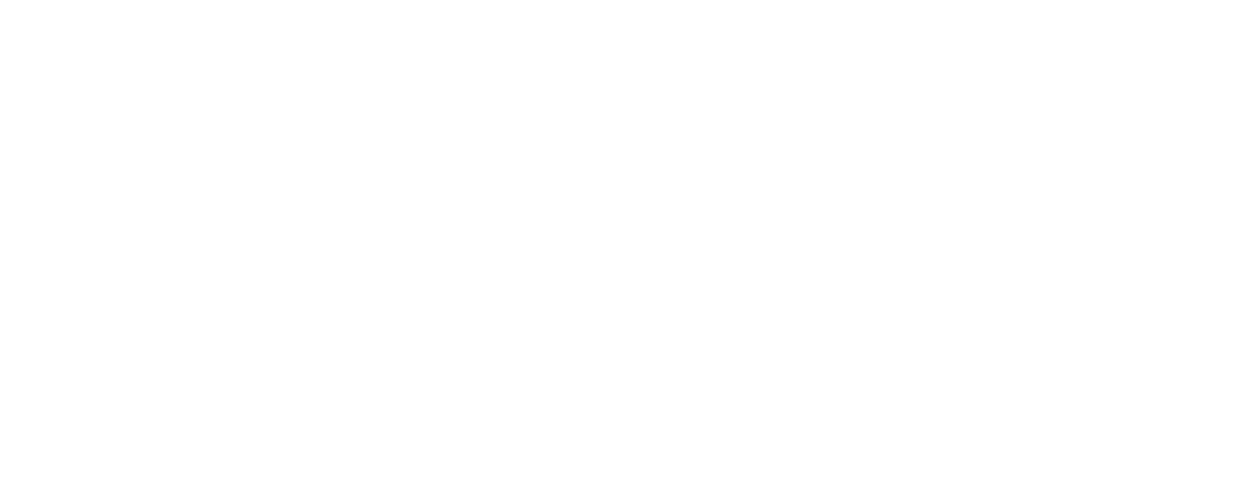

<IPython.core.display.Javascript object>


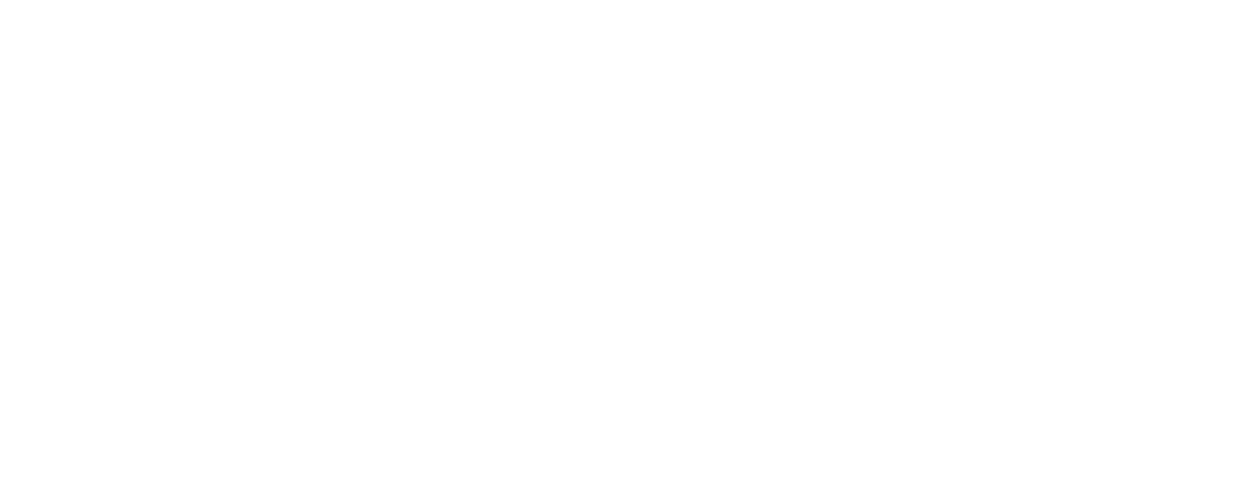

<IPython.core.display.Javascript object>


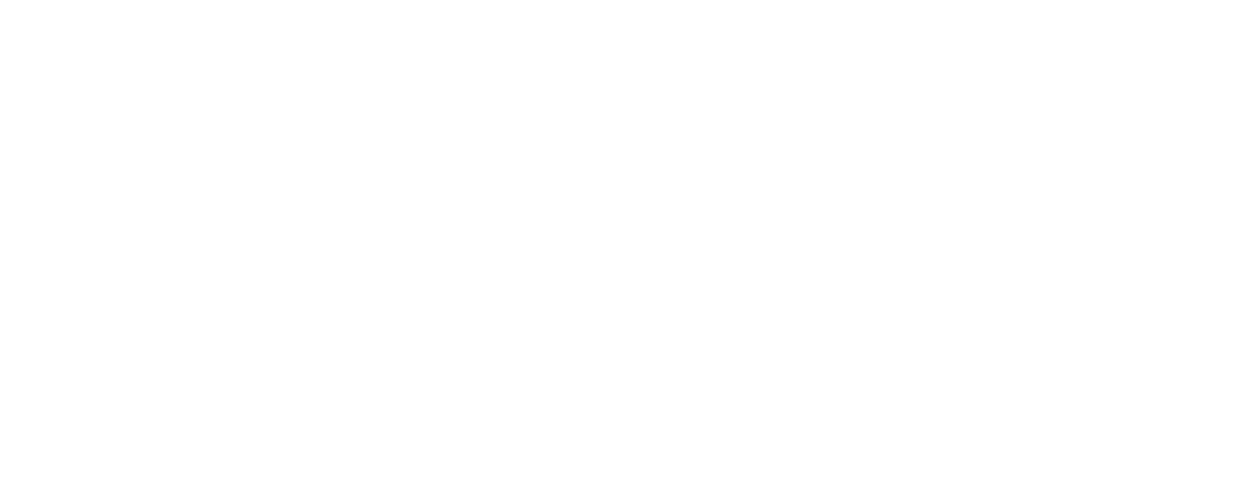

<IPython.core.display.Javascript object>


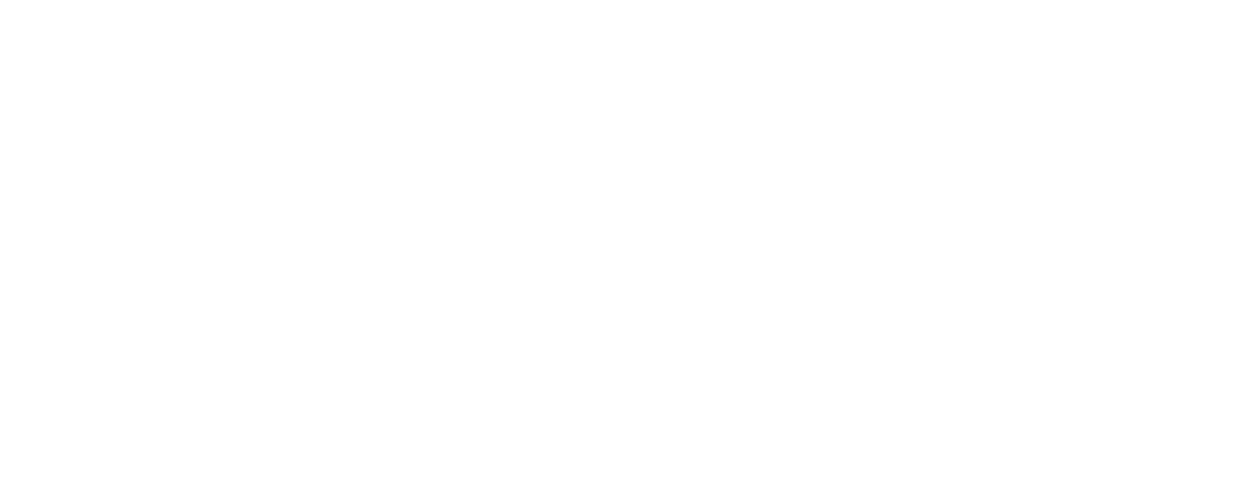

<IPython.core.display.Javascript object>


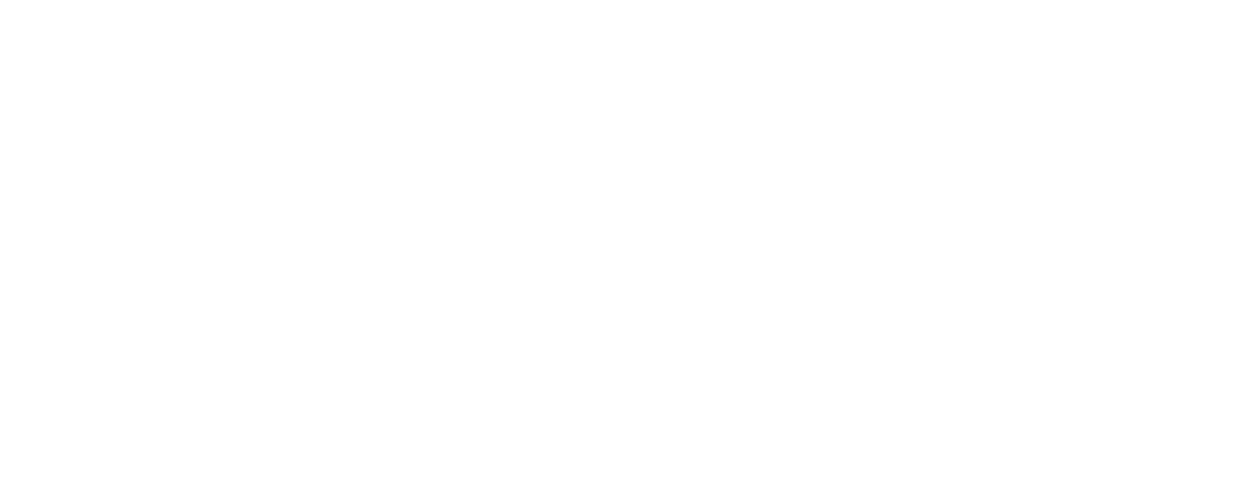

In [78]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,region_with_pickups[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,region_with_pickups[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,region_with_pickups[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


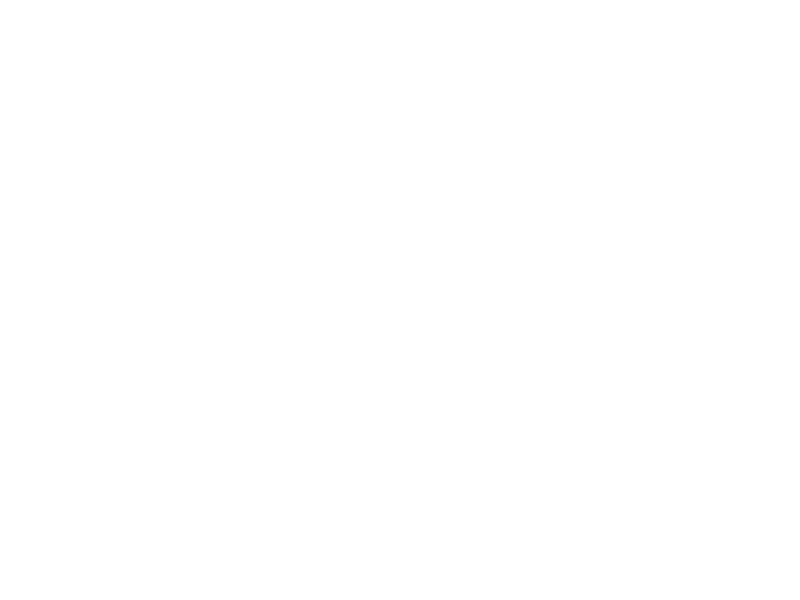

<IPython.core.display.Javascript object>


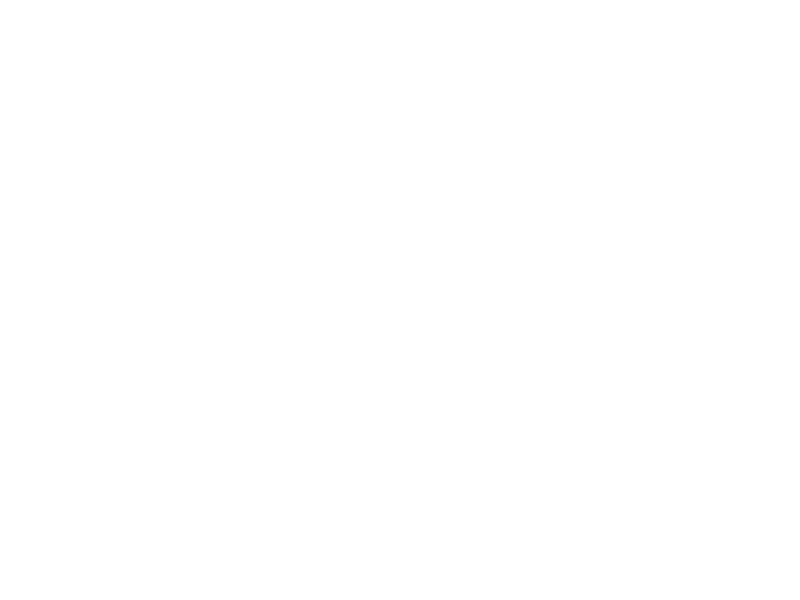

<IPython.core.display.Javascript object>


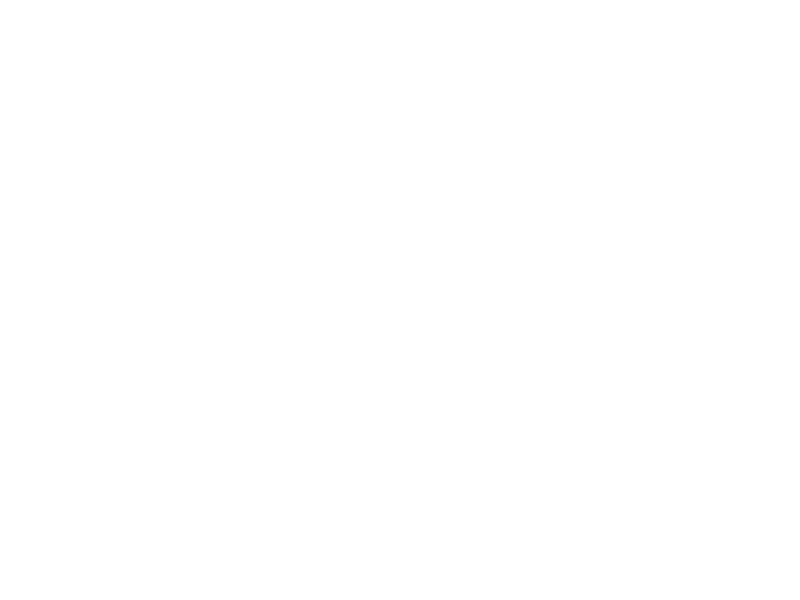

<IPython.core.display.Javascript object>


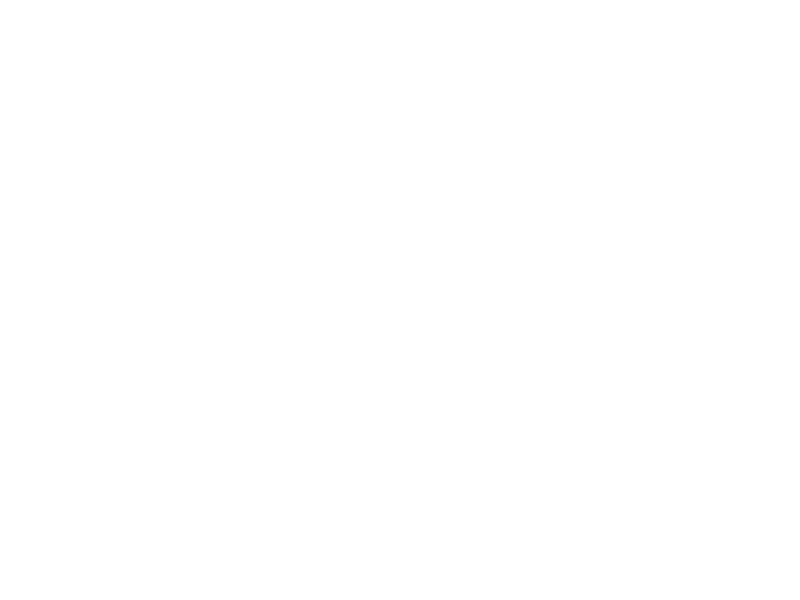

<IPython.core.display.Javascript object>


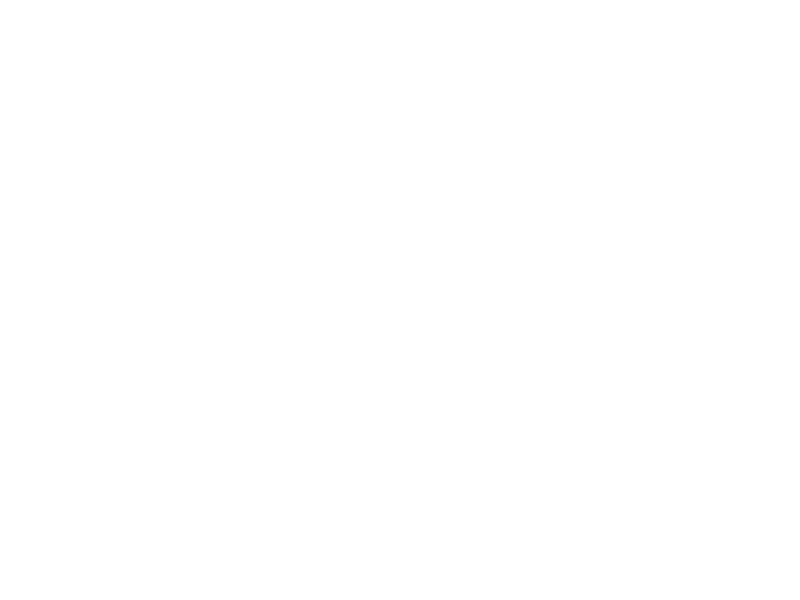

<IPython.core.display.Javascript object>


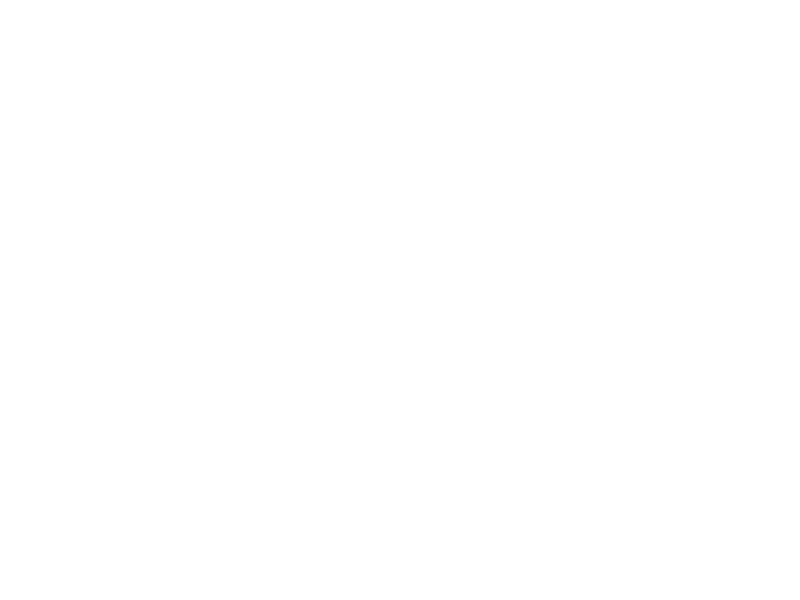

<IPython.core.display.Javascript object>


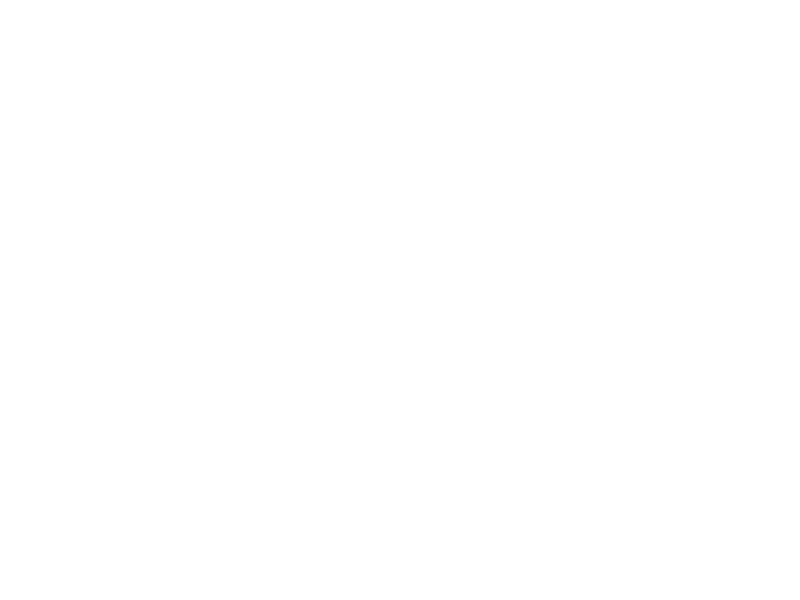

<IPython.core.display.Javascript object>


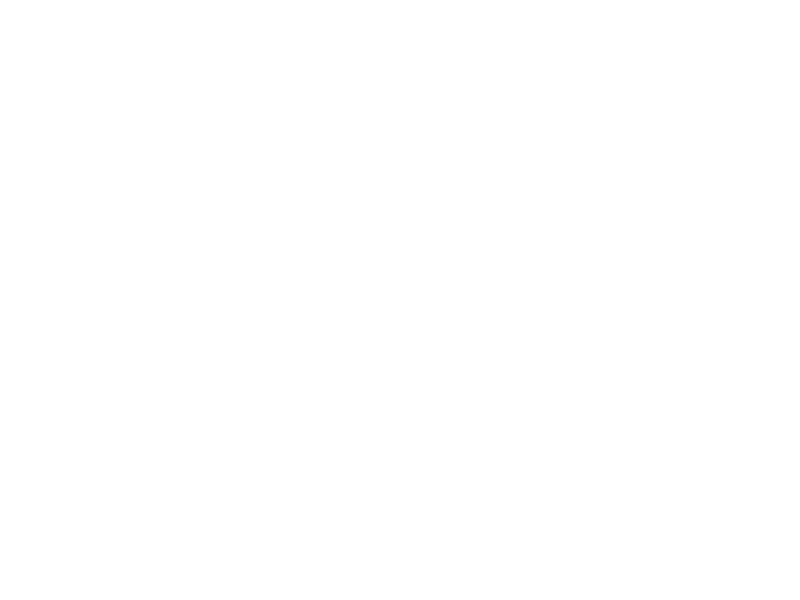

<IPython.core.display.Javascript object>


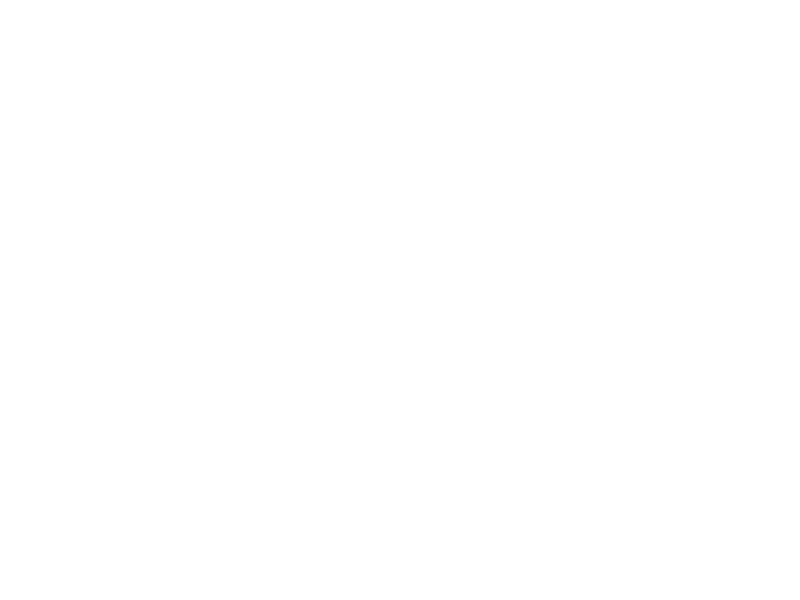

<IPython.core.display.Javascript object>


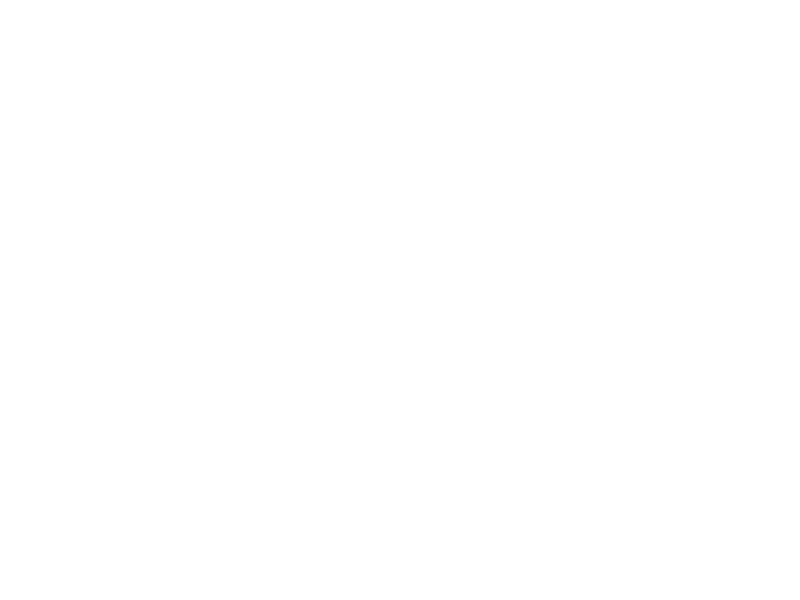

<IPython.core.display.Javascript object>


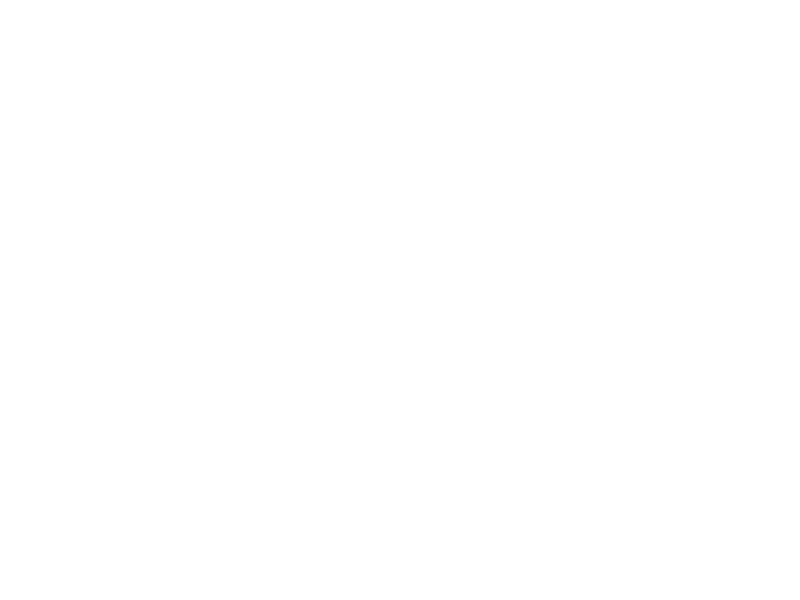

<IPython.core.display.Javascript object>


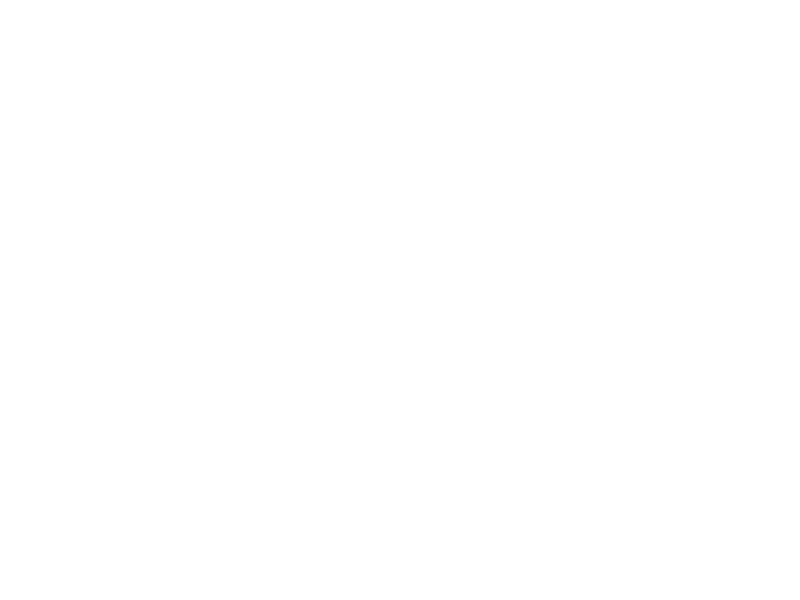

<IPython.core.display.Javascript object>


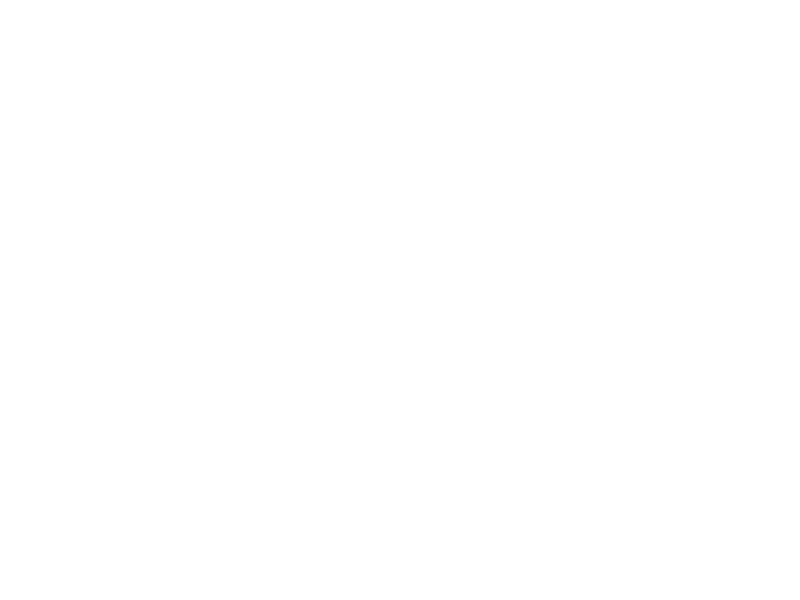

<IPython.core.display.Javascript object>


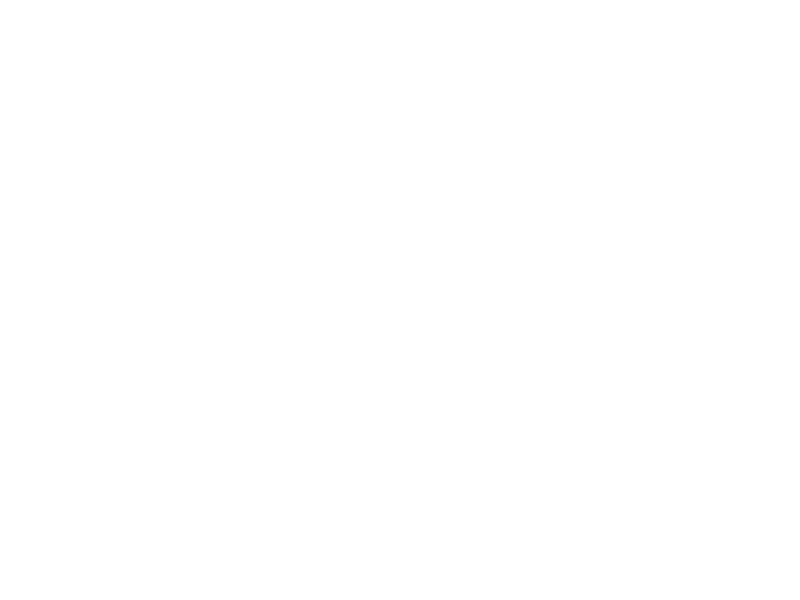

<IPython.core.display.Javascript object>


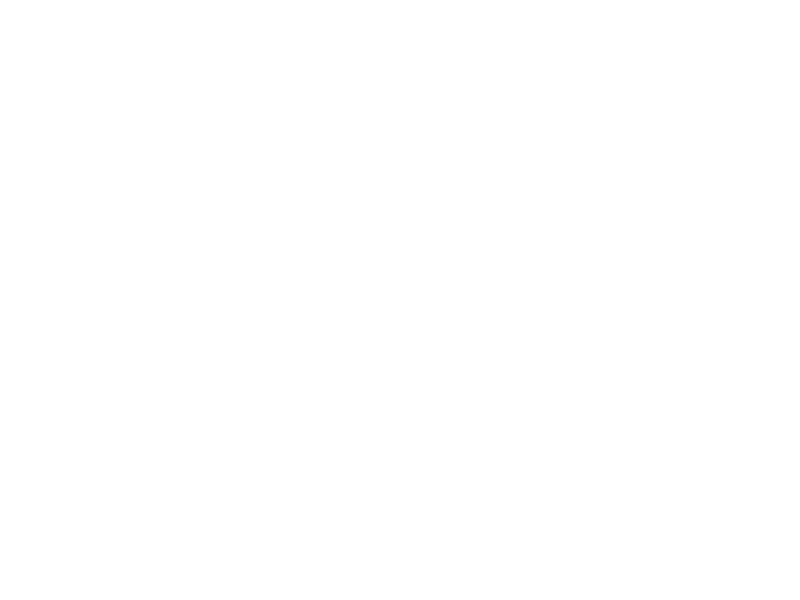

<IPython.core.display.Javascript object>


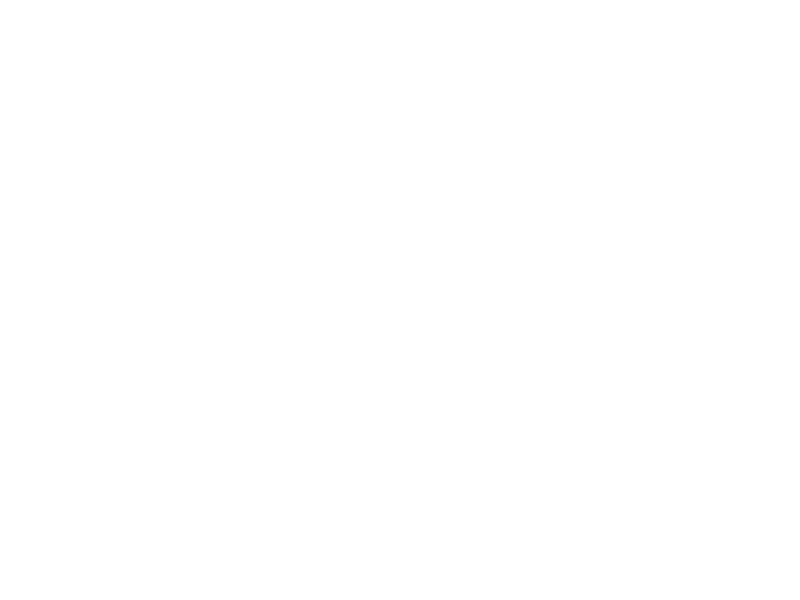

<IPython.core.display.Javascript object>


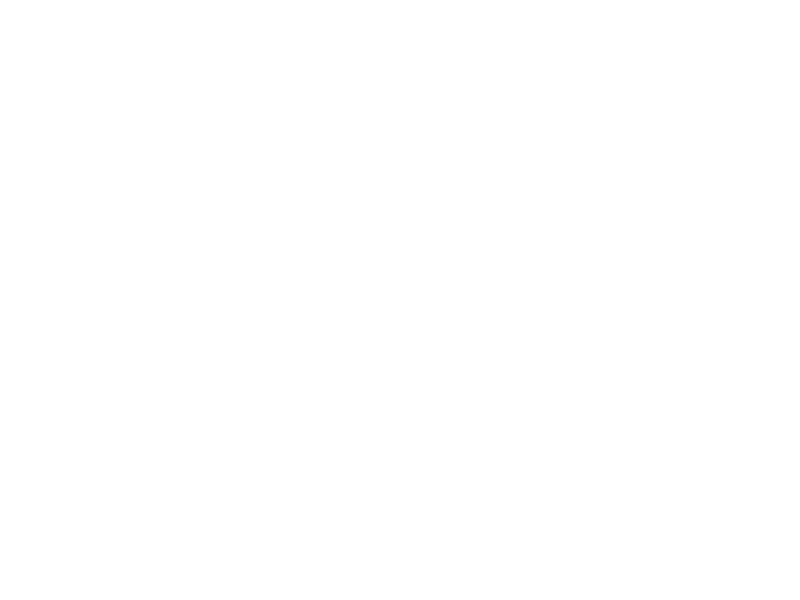

<IPython.core.display.Javascript object>


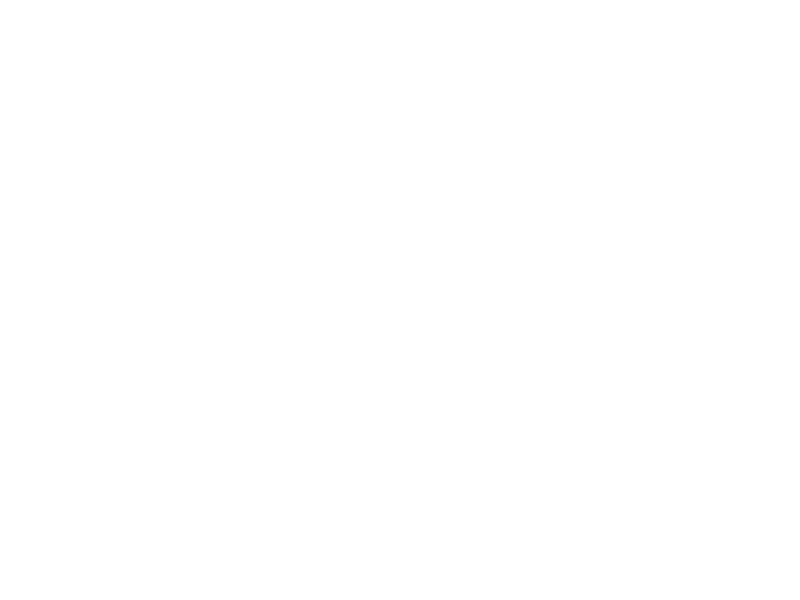

<IPython.core.display.Javascript object>


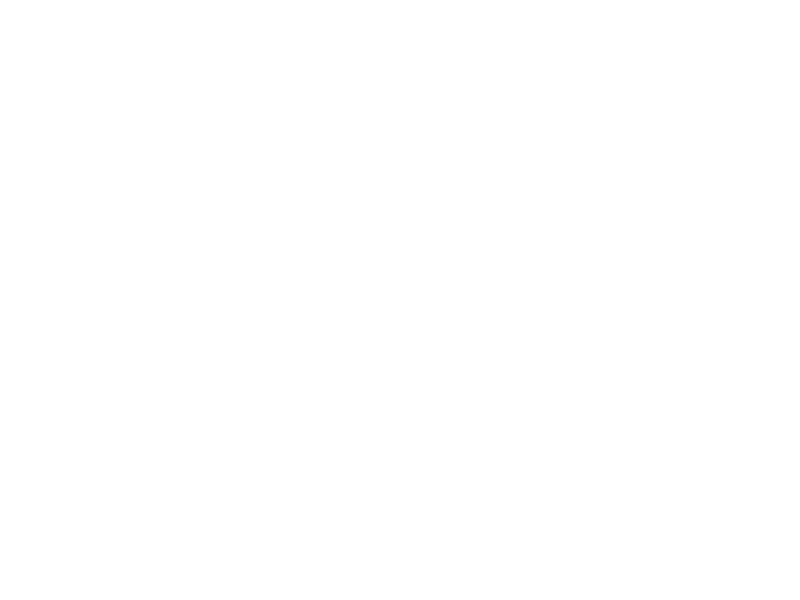

<IPython.core.display.Javascript object>


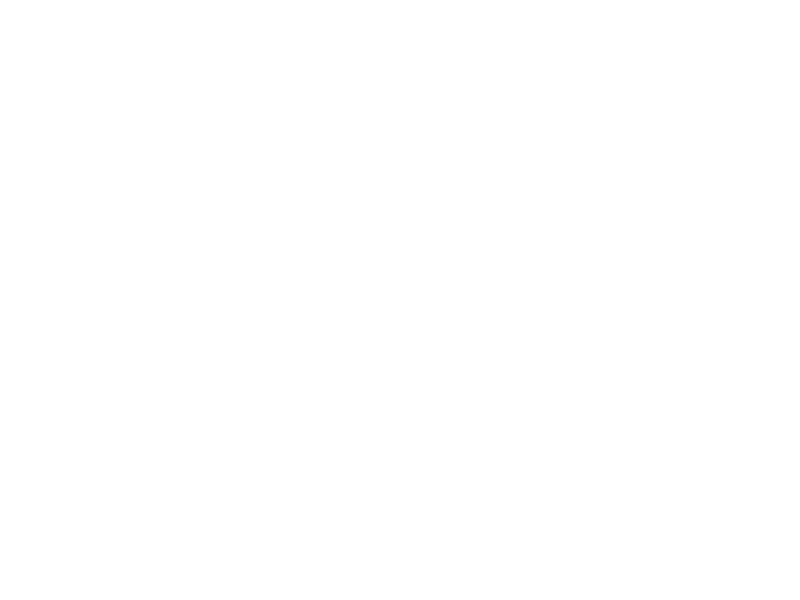

<IPython.core.display.Javascript object>


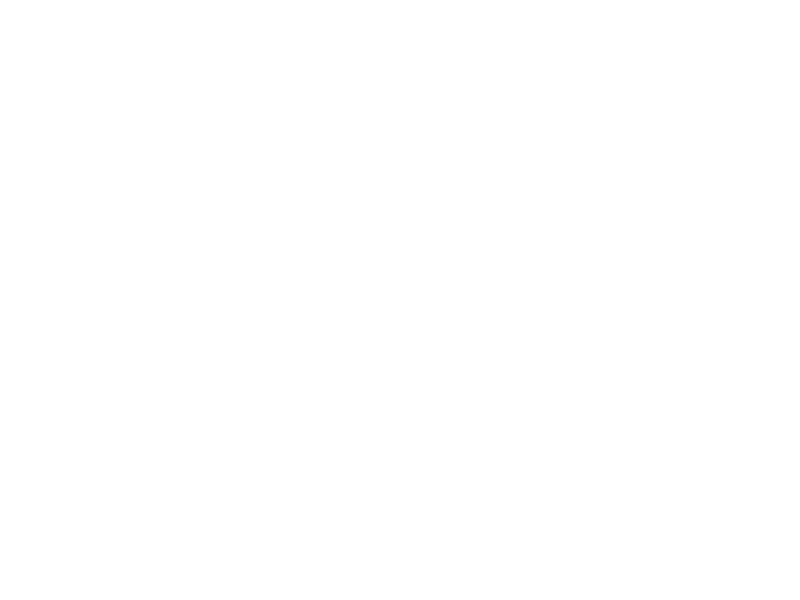

<IPython.core.display.Javascript object>


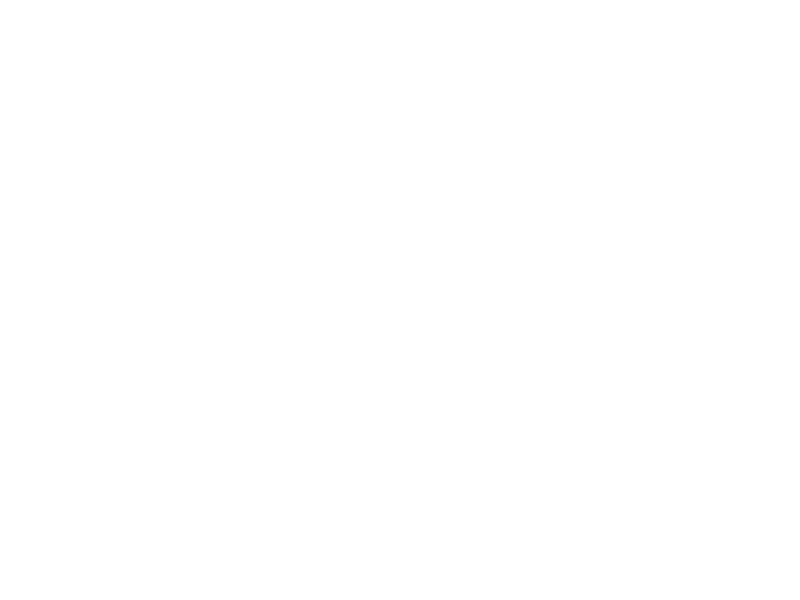

<IPython.core.display.Javascript object>


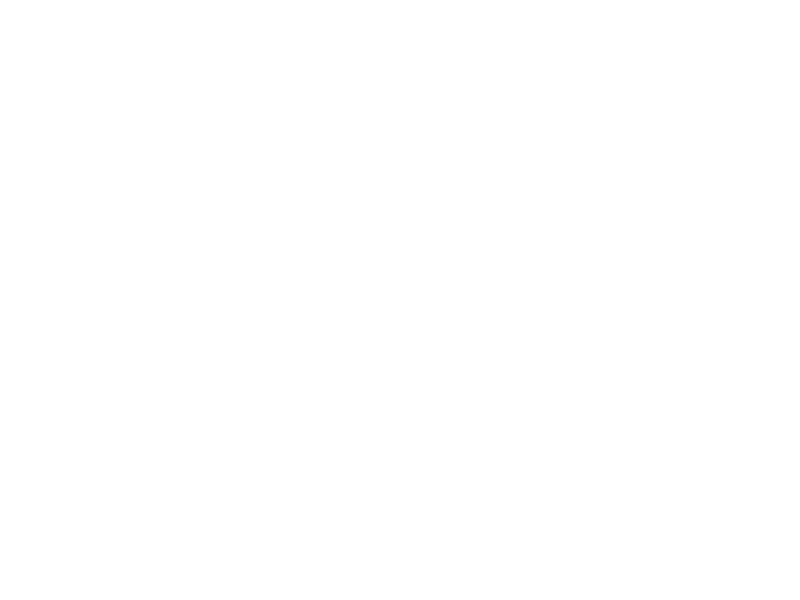

<IPython.core.display.Javascript object>


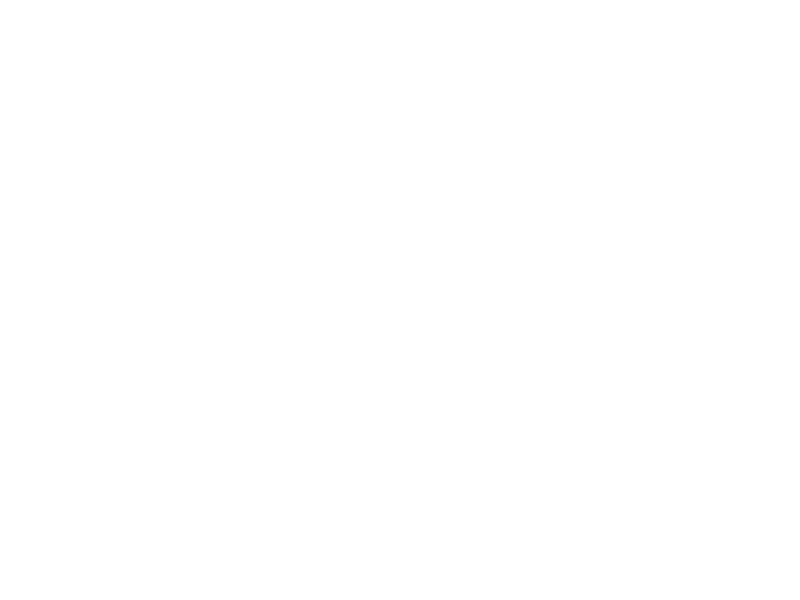

<IPython.core.display.Javascript object>


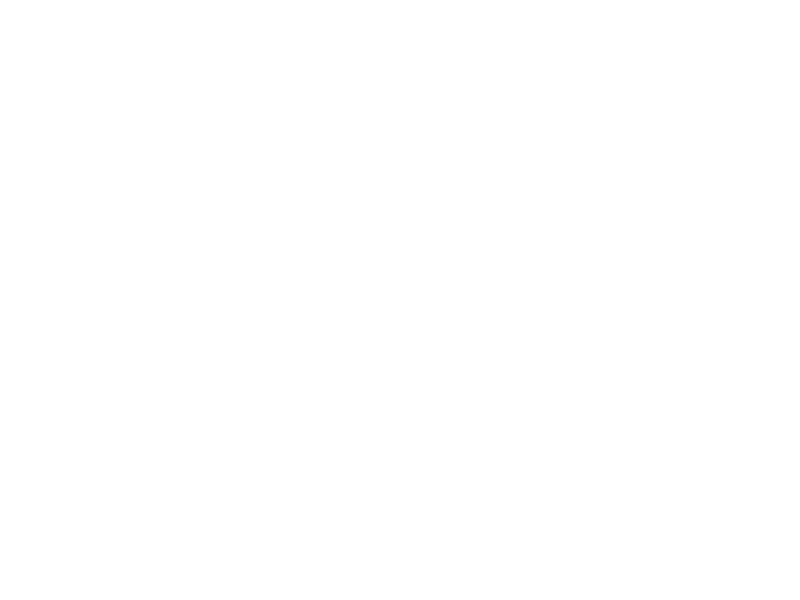

<IPython.core.display.Javascript object>


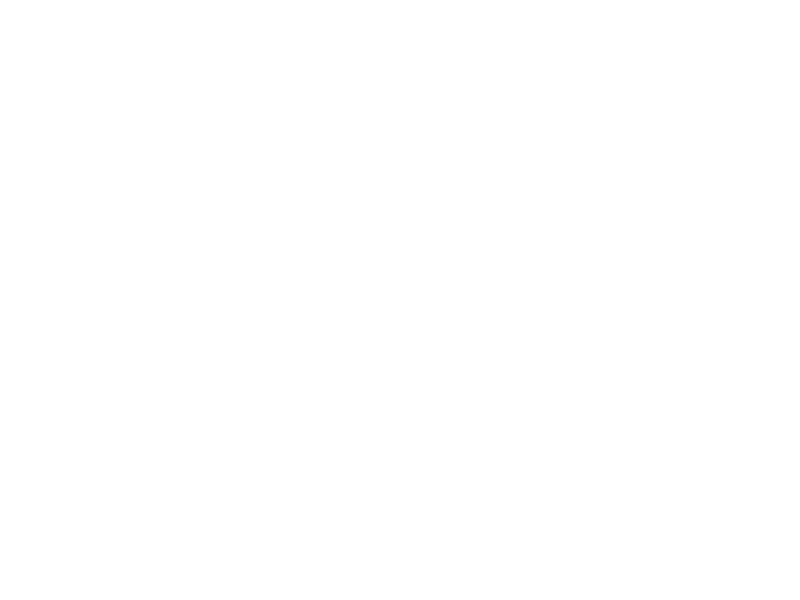

<IPython.core.display.Javascript object>


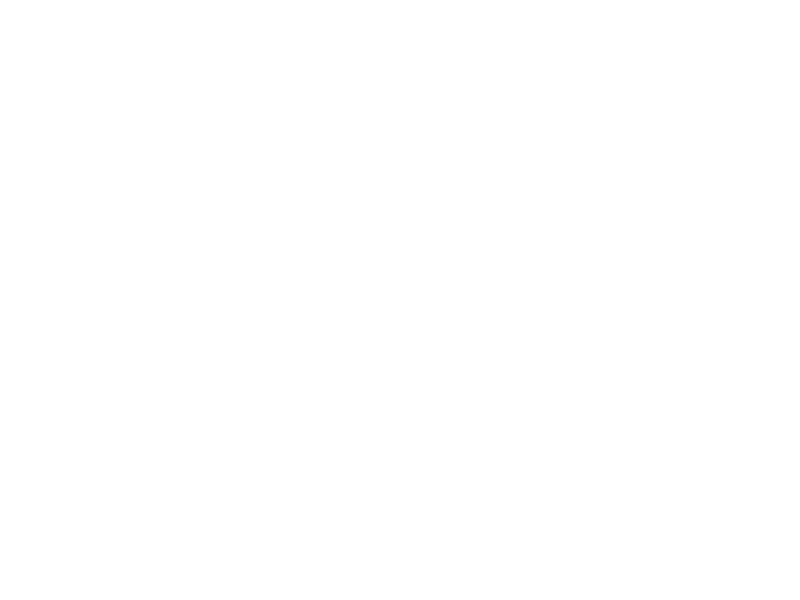

<IPython.core.display.Javascript object>


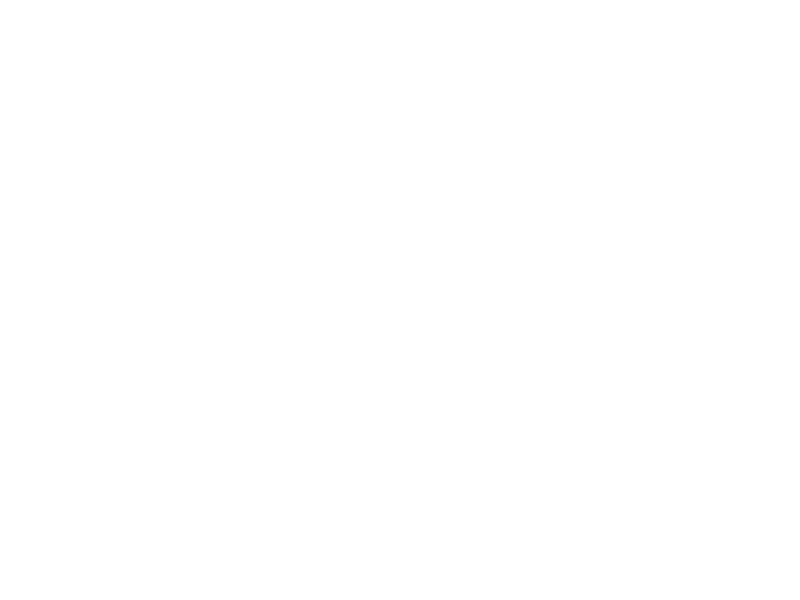

<IPython.core.display.Javascript object>


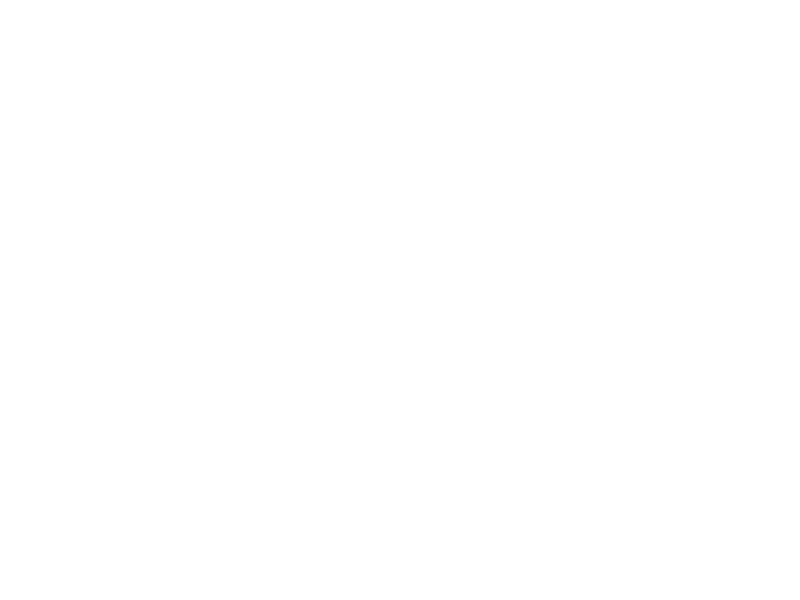

<IPython.core.display.Javascript object>


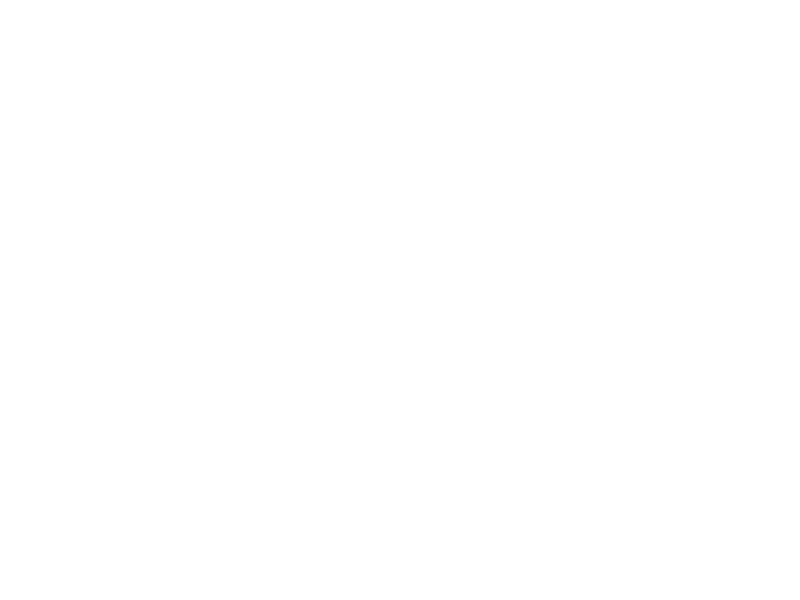

<IPython.core.display.Javascript object>


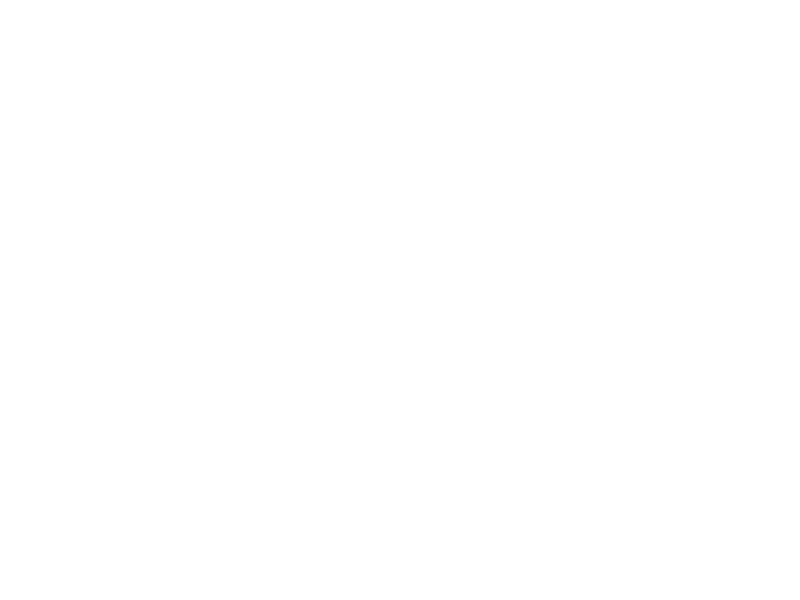

In [80]:
# https://stackoverflow.com/questions/59979354/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-fftfreq
for i in range(40):
    Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460]) # Gives you the Amplitude for corresponding frequency
    freq = np.fft.fftfreq(4460, 1) # It returns the corresponding frequency
    n = len(freq) 
    plt.figure()
    plt.plot( freq[0:int(n/2)], np.abs(Y)[0:int(n/2)] )
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

In [81]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [82]:
ratios_jan.head()

Given  Prediction    Ratios
0     46           0  0.000000
1     46          86  1.869565
2    187         226  1.208556
3    200         208  1.040000
4    276         211  0.764493

In [83]:
ratios_jan.shape

(138384, 3)

In [84]:
4464*31

138384

In [85]:
ratios_jan['Ratios'].values[2]

1.2085561497326203

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [86]:
def simple_moving_average_ratios(ratios,window_size = 3):
    predicted_ratios = (ratios['Ratios'].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_ratio_values.append(predicted_ratios)
            pickup_value = int(((ratios['Given'].values)[i])*predicted_ratios)
                           
            predicted_pickup_values.append(pickup_value)
            absolute_error.append( abs(ratios['Prediction'].values[i] - pickup_value))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - pickup_value), 2))
        
        if (i+1)>window_size:
            predicted_ratios = sum(ratios['Ratios'].values[(i+1) - window_size : (i+1) ])
            predicted_ratios = predicted_ratios/window_size
        else :
            predicted_ratios = sum(ratios['Ratios'].values[0: (i+1)])
            predicted_ratios = predicted_ratios/ (i+1)
    
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

>>#### Here, if we calculate absolute percentage error by this formulae: 
>>#### "error = (abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i])) / ratios["Prediction"].values[i]"
>>#### then it will lead to divide by zero problem because many of the values in " ratios["Prediction"].values[i]" are zeros.
>>#### so we used this method to calculate mean absolute percentage error: "mean of error/mean of real values"

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [87]:
def simple_moving_average_predictions(ratios,window_size = 2):
    predicted_pickups = (ratios['Prediction'].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_pickup_values.append(predicted_pickups)
            absolute_error.append( abs(ratios['Prediction'].values[i] - predicted_pickups))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - predicted_pickups), 2))
        
        if (i+1)>window_size:
            predicted_pickups = sum(ratios['Prediction'].values[(i+1) - window_size : (i+1) ])
            predicted_pickups = predicted_pickups/window_size
        else :
            predicted_pickups = sum(ratios['Prediction'].values[0: (i+1)])
            predicted_pickups = predicted_pickups/ (i+1)
    
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $P_{t} = ( P_{t-1} + P_{t-2} ) / 2$

### For simple_moving_average_ratios
1. With window_size = 1, mape =  0.18285850635365408
2. With window_size = 2, mape =  0.1688335553906591
3. With window_size = 3, mape =  0.1667194088154842
4. With window_size = 4, mape =  0.1680117956449372
5. With window_size = 5, mape =  0.17056104138823114

###### So , Lowest mape1 is 0.166 with 3 as window_size

### For simple_moving_average_predictions
1. With window_size = 1  mape =  0.13066319215588856
2. With window_size = 2  mape =  0.12709951604759195
3. With window_size = 3  mape =  0.13198831115869905
4. With window_size = 4  mape =  0.140098303951967

###### So, Lowest mape2 is 0.127 with 2 as window size

## Simple Weighted Moving Average
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values: $R_t = (N*R_{t-1} + N-1*R_{t-2} + N-2*R_{T-3} + ...) / N*(N+1)/2$

In [88]:
def weighted_moving_average_ratios(ratios,window_size = 4):
    predicted_ratios = (ratios['Ratios'].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_ratio_values.append(predicted_ratios)
            pickup_value = int( ((ratios['Given'].values)[i])*predicted_ratios)
            predicted_pickup_values.append(pickup_value)
            absolute_error.append( abs(ratios['Prediction'].values[i] - pickup_value))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - pickup_value), 2))
        
        temp = []
        total_weight = 0
        if (i+1)>= window_size:
            for j in range(window_size, 0, -1):
                temp.append( j * ratios['Ratios'].values[i - window_size + j ] )
                total_weight += j
            predicted_ratios = sum(temp)/total_weight
            
        else :
            for j in range(i+1, 0, -1):
                temp.append( j * ratios['Ratios'].values[j-1] )
                total_weight += j
            predicted_ratios = sum(temp)/ total_weight
                 
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 4 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ R_{t} = ( 4*R_{t-1} + 3*R_{t-2} + 2*R_{t-3} + 1*R_{t-4})/10$

Weighted Moving Averages using Previous 2016 Values - $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [89]:
def weighted_moving_average_predictions(ratios,window_size = 2):
    predicted_pickups = (ratios['Prediction'].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_pickup_values.append(predicted_pickups)
            absolute_error.append( abs(ratios['Prediction'].values[i] - predicted_pickups))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - predicted_pickups), 2))
        
    
        temp = []
        total_weight = 0
        if (i+1)>= window_size:
            for j in range(window_size, 0, -1):
                temp.append( j * ratios['Prediction'].values[i - window_size + j ] )
                total_weight += j
            predicted_pickups = sum(temp)/total_weight
            
        else :
            for j in range(i+1, 0, -1):
                temp.append( j * ratios['Prediction'].values[j-1] )
                total_weight += j
            predicted_pickups = sum(temp)/ total_weight
            
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ P_t = ( 2*P_{t-1} + 1*P_{t-2})/2$

### For weighted_moving_average_ratios
1. With window_size =  1  , mape is =  0.18285850635365408
2. With window_size =  2  , mape is =  0.1681935817171273
3. With window_size =  3  , mape is =  0.1640012876749043
4. With window_size =  4  , mape is =  0.16313448192477242
5. With window_size =  5  , mape is =  0.16372620548479394
6. With window_size =  6  , mape is =  0.16510095676582504

###### So , Lowest mape3 is 0.16313 with 4 as window_size

### For weighted_moving_average_prediction
1. With window_size =  1  , mape is =  0.13066319215588856
2. With window_size =  2  , mape is =  0.12472186291175398
3. With window_size =  3  , mape is =  0.1258753107750227
4. With window_size =  4  , mape is =  0.1296989249460057

###### So, Lowest mape4 is 0.1247  with 2 as window_size

## Exponential Weighted Moving Average

Here we will use previous predicted result along with previous actual value to make predictions for next value.
$R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}$

$R^′_t$ is the current predicted ratio.<br>
$R^′_{t-1}$ is the previous predicted ratio.<br>
$R_{t-1}$ is the actual previous ratio.<br>
Let say alpha = 0.7.<br>
Now, when alpha = 0.7, then it means we are giving 70% weightage to the previous predicted ratio and 30% weightage to the previous actual ratio.<br>
$R^′_0$ = 0<br>
$R^′_1 = 0.7*R^′_0 + 0.3*R_0$<br>
$R^′_2 = 0.7*R^′_1 + 0.3*R_1$<br>
$R^′_3 = 0.7*R^′_2 + 0.3*R_2$<br>


In [90]:
def exponential_weighted_moving_average_ratios(ratios,alpha = 0.5):
    predicted_ratios = (ratios['Ratios'].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_ratio_values.append(predicted_ratios)
            pickup_value = int(((ratios['Given'].values)[i])*predicted_ratios)
                           
            predicted_pickup_values.append(pickup_value)
            absolute_error.append( abs(ratios['Prediction'].values[i] - pickup_value))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - pickup_value), 2))
            predicted_ratios = alpha*predicted_ratios + ( (1-alpha)*(ratios['Ratios'].values[i-1]) )
 
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

In [91]:
a = 0.7
r5,mape5,mse5 = exponential_weighted_moving_average_ratios(ratios_jan, a)
print('. With alpha = ',a, ' mape5 is = ',mape5)

. With alpha =  0.7  mape5 is =  0.18457948989452258


Here, above, alpha is a hyper-parameter which needs to be tuned manually. It is found that alpha = 0.5 gives lowest MAPE value.

$P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}$

In [93]:
def exponential_weighted_moving_average_predictions(ratios,alpha = 0.5):
    predicted_pickups = (ratios['Prediction'].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    for i in range(31*4464):
        if i%4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else :
            predicted_pickup_values.append(predicted_pickups)
            absolute_error.append( abs(ratios['Prediction'].values[i] - predicted_pickups))
            squared_error.append(math.pow(abs(ratios['Prediction'].values[i] - predicted_pickups), 2))
            predicted_pickups = alpha*predicted_pickups + (1- alpha)*(ratios['Prediction'].values[i-1])
            
    ratios['simple_moving_average_ratios_pred'] = predicted_pickup_values
    ratios['simple_moving_average_ratios_AbsError'] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error))/(sum(ratios['Prediction'])/len(ratios['Prediction']))
    mean_squared_error = sum(squared_error)/len(squared_error)
    return ratios , mean_absolute_percentage_error, mean_squared_error

In [ ]:
def hyper_calc(ratios)
    i = 1
    for a in np.arange(0.2,0.7,0.1):
        r5,mape5,mse5 = exponential_weighted_moving_average_predictions(ratios, a)
        print(i,'. With alpha = ',a, ' mape5 is = ',mape5)
        i +=1

### For exponential_weighted_moving_average_ratios :
1. With alpha =  0.3  mape5 is =  0.18445000619146962
2. With alpha =  0.4  mape5 is =  0.18131987431599336
3. With alpha =  0.5  mape5 is =  0.17960021011416616
4. With alpha =  0.6  mape5 is =  0.18001495376564808
5. With alpha =  0.7  mape5 is =  0.18457948989452258

###### So, Best alpha is 0.5 with mape5 = 0.1796002

==========================================================================================================================

### For exponential_weighted_moving_average_predictions :
1. With alpha =  0.2  mape5 is =  0.14943352906610335
2. With alpha =  0.30000000000000004  mape5 is =  0.14916266983941204
3. With alpha =  0.4000000000000001  mape5 is =  0.15050847300960024
4. With alpha =  0.5000000000000001  mape5 is =  0.1541316957866549
5. With alpha =  0.6000000000000001  mape5 is =  0.16139525912125274

###### So, Best alpha is 0.3 with mape5 = 0.1491626698


In [94]:
r1, mape1, mse1 = simple_moving_average_ratios(ratios_jan)
r2, mape2, mse2 = simple_moving_average_predictions(ratios_jan)
r3, mape3, mse3 = weighted_moving_average_ratios(ratios_jan)
r4, mape4, mse4 = weighted_moving_average_predictions(ratios_jan)
r5, mape5, mse5 = exponential_weighted_moving_average_ratios(ratios_jan)
r6, mape6, mse6 = exponential_weighted_moving_average_predictions(ratios_jan)

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [95]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mape1,"      MSE: ",mse1)
print ("Moving Averages (2016 Values) -                        MAPE: ",mape2,"       MSE: ",mse2)
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mape3,"      MSE: ",mse3)
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mape4,"      MSE: ",mse4)
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mape5,"      MSE: ",mse5)
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mape6,"      MSE: ",mse6)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1667194088154842       MSE:  512.8577147647127
Moving Averages (2016 Values) -                        MAPE:  0.12709951604759195        MSE:  229.21524345300034
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.16313448192477242       MSE:  477.44196583420046
Weighted Moving Averages (2016 Values) -               MAPE:  0.12472186291175398       MSE:  216.95246479993398
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17960021011416616       MSE:  645.6870230662504
Exponential Moving Averages (2016 Values) -         MAPE:  0.154131695

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

<b>From the above error table it is inferred that the best forecasting model for our prediction would be:-</b>
$P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$ i.e Weighted Moving Averages Predictions using 2016 Values With window size = 2.

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
1. number of 10min indices for jan 2015= 24*31*60/10 = 4464
2. number of 10min indices for jan 2016 = 24*31*60/10 = 4464
3. number of 10min indices for feb 2016 = 24*29*60/10 = 4176
4.  number of 10min indices for march 2016 = 24*31*60/10 = 4464
5. region_with_pickups: it will contain 31 lists, each list will contain 4464+4176+4464 values which represents the number of pickups that are happened for three months in 2016 data

#### print(len(region_with_pickups))
###### 40
#### print(len(region_with_pickups[0]))
###### 12960


In [239]:

number_of_time_stamps = 5


# TruePickups varaible
# it is list of lists
# It will be used as true labels/ground truth. Now since we are taking previous 5 pickups as a training data for predicting
# next pickup(here next pickup will be a true/ground truth pickup), so "TruePickups" will not contain first five pickups of each 
# cluster. It will contain number of pickups 4459 for each cluster. 
number_of_pickups = []

# lat will contain 4464-5=4459 times latitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 31 lists]
# it is list of lists
latitude = []

# lon will contain 4464-5=4459 times longitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 31 lists]
# it is list of lists
longitude = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
weekday = []

# features is a numbpy array, of shape (133770, 5). {4459*31 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
features = []

center_of_clusters = kmeans.cluster_centers_
features = [0]*number_of_time_stamps

for i in range(40):
    latitude.append([center_of_clusters[i][0]]*13099)
    longitude.append([center_of_clusters[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    weekday.append( [int((int(k/144)%7 + 4)%7) for k in range(5,4464+4176+4464)] )
     #"region_with_pickups" is a list of lists which contains 31 sub lists, where the index of each sub-list is the 
    #corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
    #in Jan 2016, hence, each sub-list is of size 4464.
    #"region_with_pickups" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 31 lists]
    #Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively
    features = np.vstack((features, [region_with_pickups[i][k : k+number_of_time_stamps] for k in range(len(region_with_pickups[i])- number_of_time_stamps)]))
    number_of_pickups.append(region_with_pickups[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
features = features[1:]

In [240]:
print(len(features))
print(len(features[0]))

406069
5


### Adding Predictions of Weighted Moving Average Predictions as a feature in our data

Getting the predictions of weighted moving averages to be used as a feature in cumulative form.

Upto now we computed 8 features for every data point that starts from 50th min of the day.
1. cluster center latitude
2. cluster center longitude
3. day of the week 
4. f_t_1: number of pickups that are happened previous t-1st 10min interval
5. f_t_2: number of pickups that are happened previous t-2nd 10min interval
6. f_t_3: number of pickups that are happened previous t-3rd 10min interval
7. f_t_4: number of pickups that are happened previous t-4th 10min interval
8. f_t_5: number of pickups that are happened previous t-5th 10min interval

From the baseline models we said that the weighted moving avarage predictions gives us the best error.
We will try to add the same weighted moving avarage predictions at time t as a feature to our data.<br>
Weighted Moving Average -> $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [219]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 13104 values
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], ... 40 lists]
predicted_pickup_values_list = []


predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later


window_size = 2
for i in range(40):
    for j in range(13104):
        if j == 0 :
            predicted_value = region_with_pickups[i][j]
            predicted_pickup_values.append(predicted_value)
        else:
            temp = []
            total_weight = 0
            if j>= window_size:
                for k in range(window_size, 0, -1):
                    temp.append( k*(region_with_pickups[i][j - window_size + (k-1) ] ))
                    total_weight += k
                predicted_value = int((sum(temp))/total_weight)
                predicted_pickup_values.append(predicted_value)

            else :
                for k in range(i+1, 0, -1):
                    temp.append( k*(region_with_pickups[i][k-1] ) )
                    total_weight += k
                predicted_value = int((sum(temp))/ total_weight)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [211]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == (13104-5)*31

True

## Data Preparation for regression models
train, test split : 70% 30% split.


Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [220]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [241]:
train_features = [features[ (i*13099) :((i*13099)+9169)] for i in range(0,31)]

test_features  = [features[ ((i*13099)+9169) : ((i+1)*13099) ] for i in range(0,31)]

In [242]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0])*len(train_features),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0])*len(test_features),"features")

Number of data clusters 31 Number of data points in trian data 9169 Each data point contains 284239 features
Number of data clusters 31 Number of data points in test data 3930 Each data point contains 121830 features


In [243]:
train_lat = [i[:9169] for i in latitude]
train_long = [i[:9169] for i in longitude]
train_weekday = [i[:9169] for i in weekday]
train_number_of_pickups = [i[:9169] for i in number_of_pickups]
train_weighted_avg = [i[:9169] for i in predicted_pickup_values_list]

In [254]:
test_lat = [i[9169:] for i in latitude]
test_long = [i[9169:] for i in longitude]
test_weekday = [i[9169:] for i in weekday]
test_number_of_pickups = [i[9169:] for i in number_of_pickups]
test_weighted_avg = [i[9169:] for i in predicted_pickup_values_list]

In [255]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(40):
    test_new_features.extend(test_features[i])

In [256]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_flat_lat = sum(train_lat, [])
train_flat_long = sum(train_long, [])
train_flat_weekday = sum(train_weekday, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_number_of_pickups_flat = sum(train_number_of_pickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_long = sum(test_long, [])
test_flat_weekday = sum(test_weekday, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_number_of_pickups_flat = sum(test_number_of_pickups, [])

In [257]:
# Preparing the data frame for our train data

columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['latitude'] = train_flat_lat
df_train['longitude'] = train_flat_long
df_train['weekday'] = train_flat_weekday
df_train['weightedAvg'] = train_weighted_avg_flat
print(df_train.shape)

(284239, 9)


In [258]:
# Preparing the data frame for our test data

columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['latitude'] = test_flat_lat
df_test['longitude'] = test_flat_long
df_test['weekday'] = test_flat_weekday
df_test['weightedAvg'] = test_weighted_avg_flat
print(df_test.shape)

(121830, 9)


In [259]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1   latitude  longitude  weekday  weightedAvg
0     0    86   226   208   211  40.751098 -73.975753        4          210
1    86   226   208   211   206  40.751098 -73.975753        4          207
2   226   208   211   206   231  40.751098 -73.975753        4          222
3   208   211   206   231   228  40.751098 -73.975753        4          229
4   211   206   231   228   243  40.751098 -73.975753        4          238

In [260]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1   latitude  longitude  weekday  weightedAvg
0   163   150   152   139   156  40.751098 -73.975753        4          150
1   150   152   139   156   183  40.751098 -73.975753        4          174
2   152   139   156   183   196  40.751098 -73.975753        4          191
3   139   156   183   196   238  40.751098 -73.975753        4          224
4   156   183   196   238   245  40.751098 -73.975753        4          242

### Using Linear Regression

# Other try

In [ ]:
def smoothing(number_of_pickups, corresp_time_bin):
    smoothed_region = []
    repeat = 0
    ind = 0  # this will be pointer var for number_of_pickups (remember it doesn't contain 0 values, it just goes for number of pickup directly)
    for cluster in range(40):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0 :
                repeat -=1
            else :
                if t1 in corresp_time_bin[cluster]:
                    smoothed_bin.append(number_of_pickups[ind])
                    ind +=1
                else :
                    if t1 == 0 : # Means it's first time bin is 0 (hence case 1)
    #--------------------------------------Case 1 (pickups missing at the start)----------------------------------------- 
                        #When we have the first/first few values are found to be missing,hence we have no left-limit here
                        right_hand_limit = 0
                        for t2 in range(t1, 4464): # Checking till when it is 0 
                            if t2 not in corresp_time_bin[cluster]: 
                                continue
                            else :
                                right_hand_limit = t2
                                smoothed_value = (number_of_pickups[ind] * 1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind +=1
                                repeat = right_hand_limit - t1
                    else :  # t1 != 0
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in corresp_time_bin[cluster]:
                                continue
                            else :
                                right_hand_limit = t2
                                break
    #--------------------------------------Case 2 (pickups are missing at the end)----------------------------------------
                        #When we have the last/last few values are found to be missing,hence we have no right-limit here
                        if right_hand_limit == 0:
                            smoothed_value = (number_of_pickups[ind -1] * 1.0) /((4464 - t1 + 1)* 1.0 )
                            del smoothed_bin[-1]
                            for i in range(4464 - t1 + 1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = 4464 - t1 
    #--------------------------------------Case 3 (pickups are missing in the middle) -------------------------------------
                        else :
                            smoothed_value = ((number_of_pickups[ind -1] + number_of_pickups[ind])*(1.0)) /(right_hand_limit - t1 +1)*(1.0)
                            del smoothed_bin[-1]
                            for i in range(right_hand_limit - t1 +1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind +=1
                            repeat = right_hand_limit -t1
        print(cluster)
        smoothed_region.extend(smoothed_bin)       
    return  smoothed_region

# when we multiply any integer with "1.0", then it will be converted into float.

 How above smoothing function code is working:
 Above smoothing function code is working on the goal of filling values with the following idea: 

 If there are no pickups in the beginning of time_bin means if the values are missing at time bins starting from 12:00 till 
 anytime, then we will fill pickups as follows:

 Case 1:(pickups missing at the start):
 Ex1: _ _ _ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
 Ex2: _ _ x => ceil(x/3), ceil(x/3), ceil(x/3)

 Case 2:(pickups missing at the end)
 Ex1: x _ _ _ => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
 Ex2: x _ => ceil(x/2), ceil(x/2)

 Case 3:(values missing in middle)
 Ex1: x _ _ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)
 Ex2: x _ _ _ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)

In [ ]:
#Filling Missing values of Jan-2016 with 0
# here in jan_2016_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2016_fill = fill_missing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)

#Smoothing Missing values of Jan-2016
jan_2016_smooth = smoothing(jan_2016_groupby['trip_distance'].values, jan_2016_unique)

In [ ]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 35*4464 = 156240 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2016_fill))

In [ ]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for  21th cluster region
plt.figure(figsize=(10,5))
plt.plot(jan_2016_fill[4464*20:4464*21], label="zero filled values")
plt.plot(jan_2016_smooth[4464*20:4464*21], label="filled with avg values")
plt.ylim(0,45)
plt.xlim(0,2500)
plt.tick_params(labelsize = 20)
plt.legend()
plt.show()

##############################################